# State of the Union

#### Where are we at?

* First, we tried to model the data using categories from 2.5 years ago of historic data. It was then that we learned the data was random walk processes and could not be modelled when looking out this far. I did about 2 dozen different combinations of tests looking for signal in the data. Mixing and matching different forecast windows, historic data, and converted data. We finally found some winners! It looks like 1.5 or 1 year of history with daily forecast windows were the most promising indication of signal.

> * The reason it is random is because 2018 represents an unlikely trend when they lost business from one of their major customers. During this first attempt, we revealed that going back one year from todays date will yeild the most accurate historic trends. **This will definitely be something to watch in the future when their business experiences different ups and downs from outside influences**

* Next, with the one year + daily forecasts in mind, we went back and cleaned up the categories to reflect the pre-selected categories the customer created. The plan was to create a hierarchical model for each category that would then be dispersed to the individual PLU level. What happened? The individual PLU level represented random walk processes again, and the hierarchical models were not beating a "naive forecast" (aka using yesterdays value to predict todays value). Think of a heart monitor display... That's what most of the items looked like on the individual level. Baselining then random spikes in demand. 

* Clearly this is an issue with the scale of data we are dealing with. This small grocery distributor did not have the luxury of large datasets, and a lot of the products may only be ordered a handful of times. By definition, the forecast can only be as good as the data, and thus we had to figure out a work around for this. I wasn't ready to give up so easily! 

* Now here we are, this notebook represents an attempt to model the top 100 products (by revenue) that were ordered last year.

****

# Purpose of this Notebook

*The goal of this notebook is to establish a proof of concept. Is it possible to create a model for the 100 most ordered items? If we cannot beat the Naive forecast, then the data will not allow for an accurate forecast and I will reach the end of the road (well ok I will still try a regression model taking out the time series component). Regardless, this will be a pivotal test of what is possible given the data.*



# Data



* Used total revenue to gather the top 100 selling items in the past year's timeframe-- could potentially use the two year data instead of one year to get a clearer picture of the most demanded items.

*   NOTE: I tested this entire notebook measure the quantity instead of revenue per day per item, and it produced around the same results. About 25% of the items are displaying signs of random walk process'. The other data looks good with some signal to work with
*   There is no way to get around the randomness of the data. This will be inherent no matter what we do. It was worth it to try to filter, but I think the best thing to do is to try to detect it, and warn the customer of its not so great forecast, and focus on making the other ones as good as possible.




****

# Metrics

*How shall we comapre the accuracy of different models?*

Suprisingly, there is a lot of different theories revolving around the best metric. One of the most widely used metrics in forecasting for business operations is MAPE (mean absolute percentage error). This is by far the easiest to explain because it simply represents the percentage of error in our predictions out of 100%. However, the forumala for MAPE does not play well with 0's.


>> $\mbox{M} = \frac{100\%}{n}\sum_{t=1}^n  \left|\frac{A_t-F_t}{A_t}\right|$


If the predicted value was 5, but the actual value is 0: 5 divided by zero in undefined. Thus, MAPE really only works when you are not dealing with zero quantities, and given the sparsity of this dataset, there are a lot of zeroes. 

#### Thus, we will default to three metrics:

1. MAE(Mean Absolute Error)
>MAE very simply, takes the average of all the absolute values of your prediction errors. The smaller the number the better, with a 0 MAE meaning there was an average of 0 errors in your prediction!
>MAE will help us measure the difference between a baseline model and the arima model. 
>I chose MAE over MSE because I want to get a general sense of the errors as they are. I'm not so concerned with penalizing higher error with the MSE metric.
2. RMSE (Root Mean Sqaured Error)
>RMSE is very similar to MAE except it doesnt take the absolute value of the error terms, and instead squares them and then takes the square root of those squares. That effectively transforms the data from postive and negative values all the positive AND has the added bonus of really "punishing" the large errors because when you square the number it will accentuate the larger errors. 
> Like MAE, the lower the number the better, but RMSE will typically be larger that MAE because of the squared terms. 
> This will be good to compare and contrast against LARGE errors. Whereas MAE gives us a more level picture of the errors. 
3. Alpha = .05
>For all of the hypothesis testing, I will resort to the industry standard and set the significance level= .05

****

# Models

>Naive Forecast
>* A Naive forecast is simply taking the previous periods value. This works suprisingly well for random walk time series, and is the most basic/primitive model you can use.

>Moving Average
>* This will serve as a great baseline measure for the ARIMA model
>* a moving average simply makes you name a time period (say 7 days), take the average of the values in that time period, and use that predict tomorrow's value. It is up to you to choose a relevant time period.

>Simple Exponential Smoothing
>* Gives higher weights to recent data, and lower weights to older data and then takes the average of the values with the weights taken into account.

>Holts Linear Trend
>* Holts Linear Trend will do the same as the exponential smoothing, but also take into account the trend of the data

>Holts Winter Model
>* Holts Winter Method does triple exponential smoothing to try to uncover seasonality and trend.
You must calculate the correct seasonality

>Facebook Prophet Model

>Light Gradient Boost Model

# Installs:

In [0]:
#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area

#access the OS system to work with current directories:
import os 

Fri Oct 18 17:06:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

****
# 1. Setups/ Imports

In [0]:
%pip install hurst

In [0]:
#imports
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from sklearn import metrics
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.despine()
sns.set(rc={'figure.figsize':(15,9)})
%matplotlib inline

****
# 2. Importing & Prepping Data

In [0]:
#Import the cleaned up data frame with the 100 highest revenue items

#dfqty = pd.read_csv('drive/My Drive/Capstone_2/data/correct_cat_pivot.csv', index_col= 'invdate', low_memory=False)#categories to test models
#dfqty = pd.read_csv('drive/My Drive/Capstone_2/data/single_items.csv', index_col= 'invdate', low_memory=False)#TEN individual items to test models
df = pd.read_csv('drive/My Drive/Capstone_2/data/100_items.csv', index_col= 'invdate', low_memory=False)#100 highest revenue items to test models
#df = pd.read_csv('drive/My Drive/Capstone_2/data/100Q_items.csv', index_col= 'invdate', low_memory=False)#Testing Quantity instead of revenue

In [0]:
#creating a data frame with just the normalized quantities ordered.
dfqty = pd.pivot_table(df, values= "norm_qty", index= "invdate", columns = "item", aggfunc=np.sum, fill_value=0)

#Adding total columns
dfqty["day_total"]= dfqty.sum(axis = 1, skipna = True)

#resetting index to datetime
dfqty.index = pd.to_datetime(dfqty.index)


In [0]:
#filling in the missing days
idx = pd.date_range('2018-08-23', '2019-08-23')
dfqty = dfqty.reindex(idx, fill_value=0)


In [0]:
print (f'dfqty shape= {dfqty.shape} \n')

dfqty shape= (366, 101) 



In [0]:
#Whoops accidentally did 366 days instead of 365! Let's fix that...

dfqty = dfqty[1:]

In [0]:
dfqty.reset_index(inplace= True)
dfqty.head()

item      index  10218B  10219  10221  ...  90107  CV70191W  CV70192   day_total
0    2018-08-24     8.5   13.7    0.0  ...      1       1.0    1.000  644.692982
1    2018-08-25     0.0    1.0    0.0  ...      2       1.0    6.375  245.467982
2    2018-08-26     0.0    0.0    0.0  ...      0       0.0    0.000   53.000000
3    2018-08-27     3.0   14.0    0.0  ...      2       2.0    1.625  527.290132
4    2018-08-28     3.5    3.6    0.0  ...      3       0.0    0.000  542.351974

[5 rows x 102 columns]

In [0]:
#coercing the outliers --- NOTE we will decide if we want to use this--- ONLY USE IF YOU WANT COERCED DATA

for col in dfqty.columns:
  mu = dfqty[col].mean()
  std = dfqty[col].std()
  c_upper = mu + (std*2)
  
  #c_lower = mu - (std*2)#dont need to use this because got rid of all zeros
  
  dfqty[col] = dfqty[col].apply(lambda x: x if x <= c_upper else c_upper)
  
  #USE to count how many outliers there are in each category::
  #dfcoer[col] = dfqty[col].apply(lambda x: x if x <= c_upper else np.nan)  
#dfcoer.isnull().sum().sort_values()

*There are anywhere from 1- 30 outliers per item or .2%- 8% of the entire year's data*

In [0]:
#creating a list of all the different Item codes to iterate through later on
items_lst = list(dfqty.columns)

In [0]:
dfqty.head()

item          10218B  10219  10221  ...  CV70191W   CV70192   day_total
2018-08-24  6.022676   13.7    0.0  ...       1.0  1.000000  644.692982
2018-08-25  0.000000    1.0    0.0  ...       1.0  2.408881  245.467982
2018-08-26  0.000000    0.0    0.0  ...       0.0  0.000000   53.000000
2018-08-27  3.000000   14.0    0.0  ...       2.0  1.625000  527.290132
2018-08-28  3.500000    3.6    0.0  ...       0.0  0.000000  542.351974

[5 rows x 101 columns]

In [0]:
#Taking a 10% random sample of the data... 

#NOTE: I will NOT set a random seed because I perfer this to roll through the 100 items randomly each time I run this notebook

dfsamp = dfqty.sample(frac =.10, axis = 1) 

dfsamp.head()

item           20345  30762  60023   30349  ...  20231  20213  30094     40071
2018-08-24  3.900000    1.0    4.0  2.5000  ...    0.0   11.0    0.0  9.899469
2018-08-25  1.533333    0.0    1.0  1.0000  ...    0.0    1.0    0.0  5.000000
2018-08-26  0.000000    0.0    0.0  0.0000  ...    1.0    1.0    0.0  0.000000
2018-08-27  6.466667    5.5    3.0  1.0625  ...   13.0   24.0    0.0  2.000000
2018-08-28  5.800000    3.0    3.0  5.0625  ...   12.0    8.0    0.0  5.000000

[5 rows x 10 columns]

***
# 3. Decomposition (Observed, Trend, Seasonality)

#### What is it?

Basically it's a handy way to look at the abstract of timeseries data. It uses stastistical methods to break down the time series into three components (four if I included noise/residuals):

* Observed:
>* What does the data look like as it is?

* Trend:
>* does the data follow a consistent upwards or downward slope?

* Seasonality:
>* does the data display a clear periodic pattern?

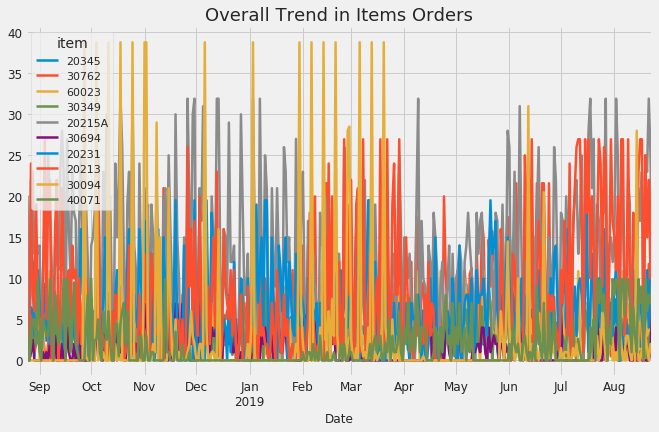

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('fivethirtyeight')

# Perform time series decompositon
decomposition = sm.tsa.seasonal_decompose(dfsamp, freq=104)

# Extract the observed time-series 
obs = decomposition.observed

# Plot the observed time series
ax = obs.plot(figsize=(10, 6), fontsize=12, linewidth = 2.5)

# Specify axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Overall Trend in Items Orders', fontsize=18)
plt.show()

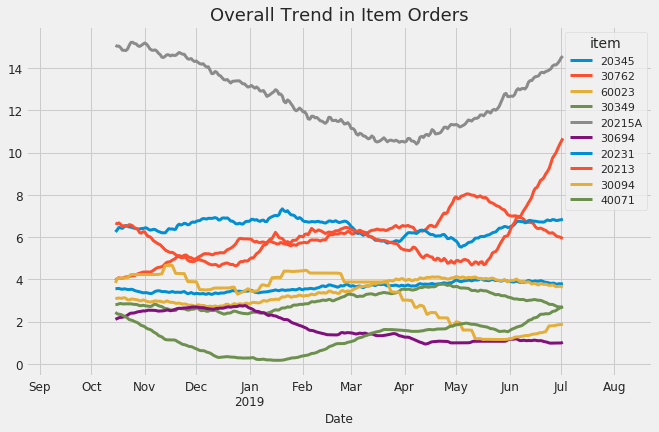

In [0]:
#A CLOSER LOOK AT THE TREND OF ITEMS

plt.style.use('fivethirtyeight')

# Perform time series decompositon
decomposition = sm.tsa.seasonal_decompose(dfsamp, freq=104)

# Extract the trend component
trend = decomposition.trend

# Plot the values of the trend
ax = trend.plot(figsize=(10, 6), linewidth= 3, fontsize=12)

# Specify axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Overall Trend in Item Orders', fontsize=18)
plt.show()

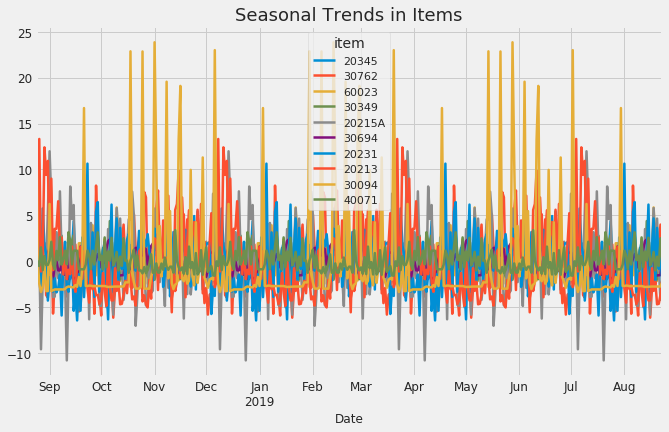

In [0]:
# A CLOSER LOOK AT SEASONALITY
seasonality = decomposition.seasonal

ax = seasonality.plot(figsize=(10, 6), fontsize=12, linewidth= 2.5)

# Specify axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Seasonal Trends in Items', fontsize=18)
plt.show()

#### Insights


* Each item has a unique trend and seasonality. 
* It is clear that the best model will be the one that can automatically capture all these nuances (perhaps look into R's Auto- ARIMA??)



# 4. Checking for White Noise 

#### What is it?

* White noise means all the entries are identically distributed with a mean of zero independent of each other
>* Basically, this means that the entries are random entries, and for timeseries forcasting we need to be able to detect patterns in the data

* Two Times to Check for White Noise:

>1. You first check for white noise in the beginning to make sure you can create a forecasting model
>2. You check after you make a prediction using your model, and make sure the residuals of your prediction ARE producing white noise. 
>>* If the errors of your model are white noise this is good because it means your model used all possible signal or trends in the data to produce it's prediction. If your model diagnostics do not produce white noise, then it means there's more you can do to improve your model.

> *In the **beginning** you do not want your data to be white noise. At the **end** you want your model to produce random residuals (white noise).*


#### Why it matters

1. This makes it impossible to make a forecasting model if there's white noise in the beginning
2. This means you can work to improve your model if you find white noise in the end

#### Characteristics of a White Noise

*   mean = close to zero
*   standard deviation = close to 1
*   constant variance

#### Difference between White Noise and a Random Walk

A random walk differs from white noise because it is talking about the steps (or chunks of time) being random & independent, but not the points themselves. Also, the variance increases linearly with each step (not constant). 

To put it simply, think the of S & P: white noise is like the daily changes of the points of the S & P, while a random walk is the S&P daily level itself.

In [0]:
dfsamp.describe()

item        20345       30762       60023  ...       20213       30094       40071
count  365.000000  365.000000  365.000000  ...  365.000000  365.000000  365.000000
mean     3.656062    5.334390    3.425934  ...    7.262355    2.964466    1.955753
std      2.648133    5.399179    3.249153  ...    8.102457    8.682146    2.921575
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%      1.800000    1.000000    0.000000  ...    1.000000    0.000000    0.000000
50%      3.333333    4.000000    3.000000  ...    4.000000    0.000000    0.000000
75%      5.266667    8.000000    6.000000  ...   11.000000    1.000000    3.000000
max      9.810682   21.595658   10.872874  ...   26.958855   38.783121    9.899469

[8 rows x 10 columns]

#### Insights:
* Shoot! Some of our items are showing an average demand close to 0 each day. This maybe problamtic for the model...
* I will invetigate this further, but perhaps I will go back and base the 100 items on total normalized quantity instead.

# 5. Checking for Random Walks
#### What is it?
* Random Walks typically happen in financial data a lot. It basically means the data is taking successive steps that are random (think a literal "random walk"). The steps are successive, but not predictable. Within each period the variable takes a random step away from its previous value, and the steps are independently and identically distributed in size (“i.i.d.”). 
* This concept was popularized in 1973 with the publishing of "A Random Walk Down Wallstreet" [book link](https://https://en.wikipedia.org/wiki/A_Random_Walk_Down_Wall_Street)
* The best prediction for a random walk is to look at the previous "step" or timeframe and use that to predict the future value. This is called a "Naive" or baseline forecast.
* If we dont have a random walk process, we will not be able to predict future changes.

#### Why it matters?
* It is important that we will not be diving into creating complicated models for random walk processes because they won't be able to beat the naive model.

#### How to check?
1. We will be using the Augmented Dickey-Fuller hypothesis test. With this test, the null hypothesis is that the time series IS a non-stationary series. Thus, we want all the p-values to be below .05 which means we have a 5% or less chance to see a value this extreme or greater, and we can reject the null hypothesis that they are non-stationary

2. Check the Hurst Exponent

3. Check correlogram plots of original data.

4. Check correlogram plots for the converted stationary data.

5. Does the Naive model outperform more complicated models? We will measure this in sections 6, 7, & 8.


## 5.1 Checking for Stationarity

In [0]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

non_stat_items = {}
for col in dfqty.columns:
   results = adfuller(dfqty[col])
   if results[1] > .05:
      non_stat_items[col]= results[1]

print (f"Number of stationary items =  {len(dfqty.columns) - len(non_stat_items)}")
print(f"Number of non-stationary items =  {len(non_stat_items)}")
print( f"\n Items that are not stationary:\n\n {non_stat_items} ")

Number of stationary items =  64
Number of non-stationary items =  37

 Items that are not stationary:

 {'10238': 0.3666052742907297, '10241': 0.10870044771539628, '10330J': 0.0754268471888806, '10346': 0.07937006914335759, '10370': 0.07708268973214914, '10513': 0.6127411771004742, '20050': 0.08413937436908309, '20088': 0.11015834838464755, '20190': 0.2875421578540033, '20213': 0.16620102514911644, '20215A': 0.1790772544923701, '20234C': 0.676489027791789, '20302A': 0.13752084599174408, '20318': 0.06721139335086036, '20328A': 0.08314159496361495, '20348B': 0.19381761303220407, '20384': 0.052453643116733645, '30070': 0.11802826232290226, '30094': 0.07440442638327906, '30131': 0.1577666274124136, '30239': 0.09853271756271798, '30298A': 0.18221143563447956, '30323': 0.1309581213813127, '30377': 0.3440443637903996, '30385': 0.10204911898903435, '30492': 0.1988202759496605, '30683': 0.10949435512791816, '40071': 0.6683819981363199, '40088': 0.11349278240115102, '50112': 0.4681499535475722,

#### Insights

* We could manipulate just the non-stationary items by differencing them, or we could difference the entire dataframe to help improve the simple classical models. 
* This will be something to keep in the back pocket. 

In [0]:
# #Logging the data frame to transform the data into stationary

# dflog = np.log(dfqty)
# dflog.dropna(inplace= True)
# dflog.plot()
# plt.title("Log Graph")

In [0]:
#Differencing the data frame to transform the data into stationary

# diff = dfqty - dfqty.shift(1)
# diff.dropna(inplace= True)
# diff.plot()
# plt.title("Diff Graph")

In [0]:
# checking for stationarity after differencing

# print ("Checking for stationarity with difference data")
# for col in diff.columns:
#    results = adfuller(diff[col])
#    print (f"{col} p-value= {str(results[1])}")

## 5.2 Hurst Exponent
* The Hurst Exponenent is another way to measure if a time series is a random walk. 
* If the Hurst exponent is > .5 it is trending
* < .5 and its anti-persistent time series
* Close to .5 and its a random walk

In [0]:
from hurst import compute_Hc, random_walk

#hurst test for the un-altered data

hurst_bad = {}
for col in dfqty.columns:
  H, c, data = compute_Hc(dfqty[col], kind='change', simplified=True)
  if (H >= .45 and H <= .55):
    hurst_bad[col]= H

print(f"Number of items indicating a random walk =  {len(hurst_bad)}")
print (f"Number of items not indicating a random walk =  {len(dfqty.columns) - len(hurst_bad)}")
print( f"\n Items that are potentially random walks:\n\n {hurst_bad} ")


#hurst for the differenced data

# print ("\nDifferenced Data:\n")
# for col in diff.columns:
#   H, c, data = compute_Hc(diff[col], kind='change', simplified=True)
#   if (H >= .45 and H <= .55):
#     hurst_bad[col]= H

# print(f"Number of items indicating a random walk =  {len(hurst_bad)}")
# print (f"Number of items not indicating a random walk =  {len(dfqty.columns) - len(hurst_bad)}")
# print( f"\n Items that are potentially random walks:\n\n {hurst_bad} ")

Number of items indicating a random walk =  0
Number of items not indicating a random walk =  101

 Items that are potentially random walks:

 {} 


#### Insights
* Not terrible! Still would prefer to see NO indication of any random walks, but lets take a peek at the correlograms of these
* None of the Hurst exponent red flags were represented in the stationary test. Something to note and question.

## 5.3 Correlogram Plots



*   Let's visualize the 100 items to see how related they are to their pasts

* Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. 


Correlogram of the Different Categories with Regular Data = Red



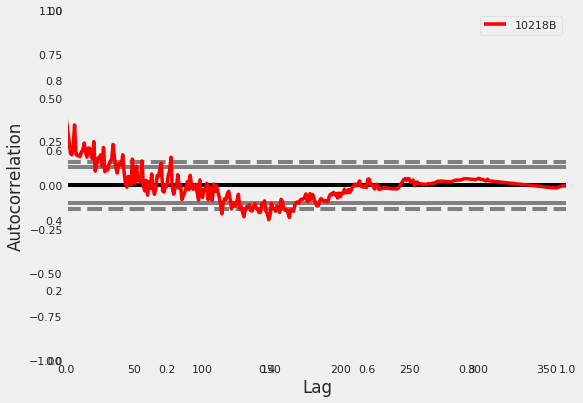

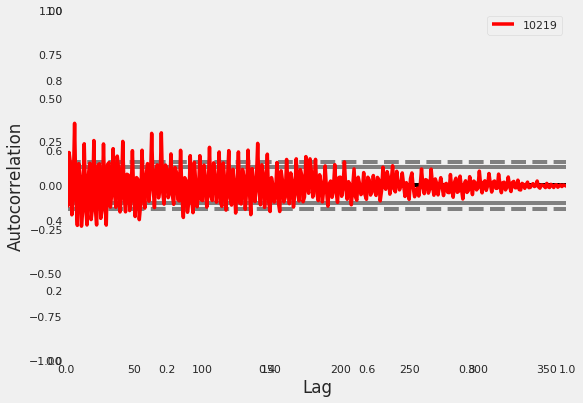

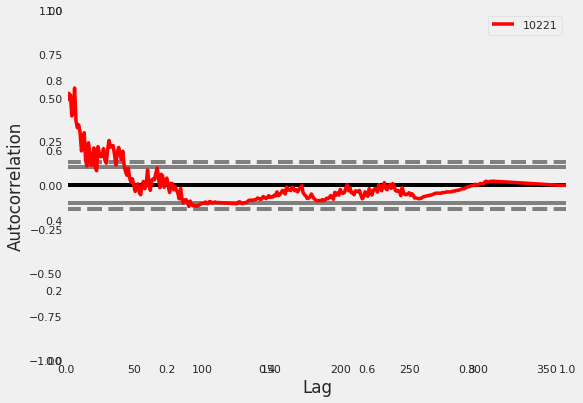

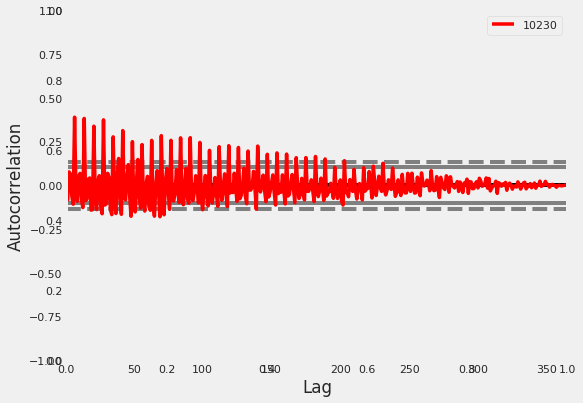

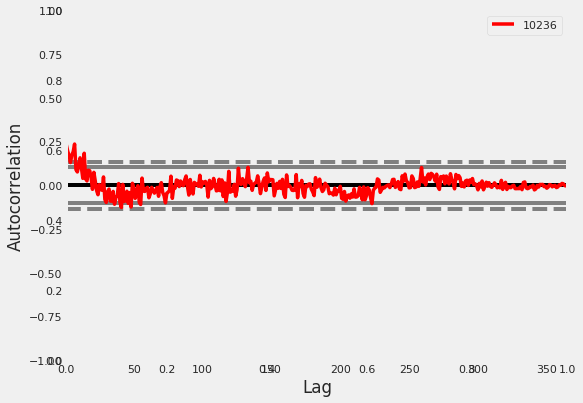

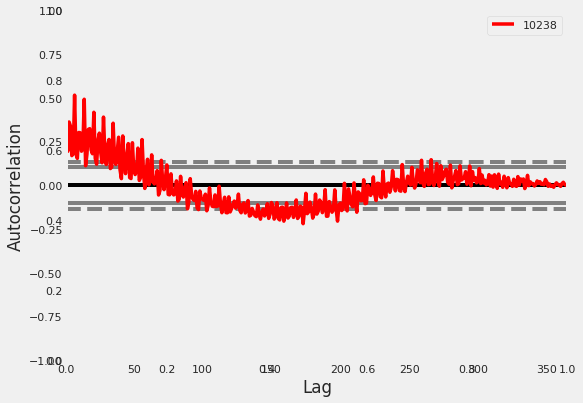

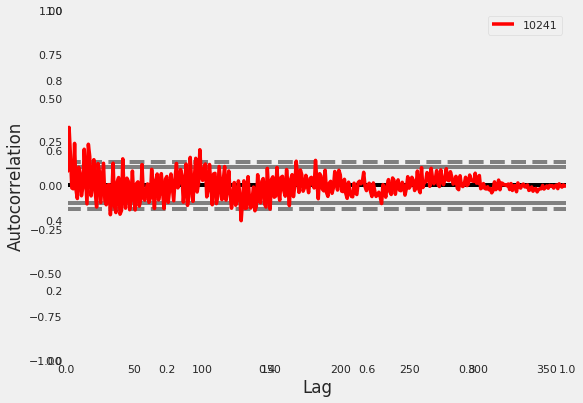

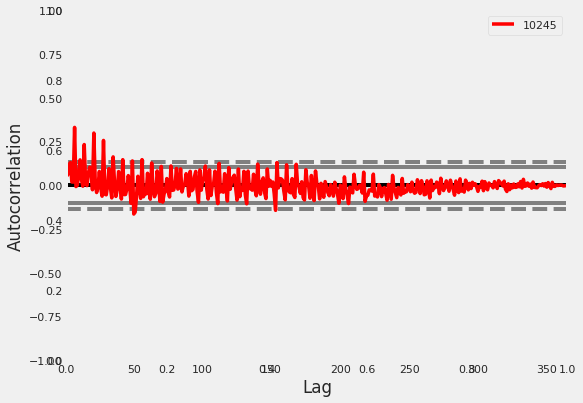

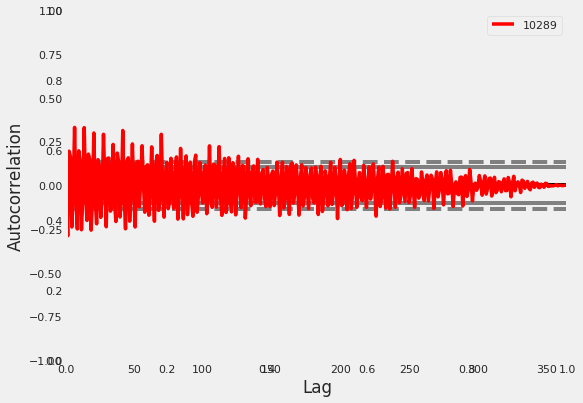

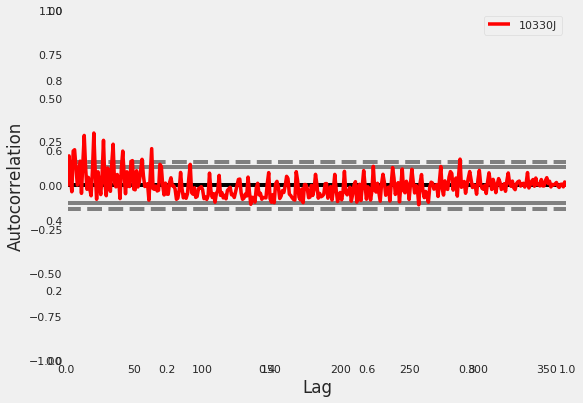

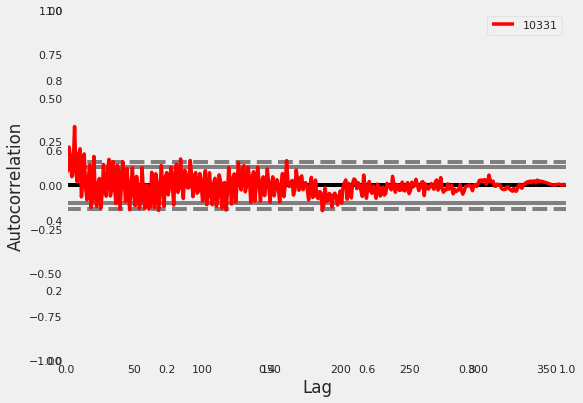

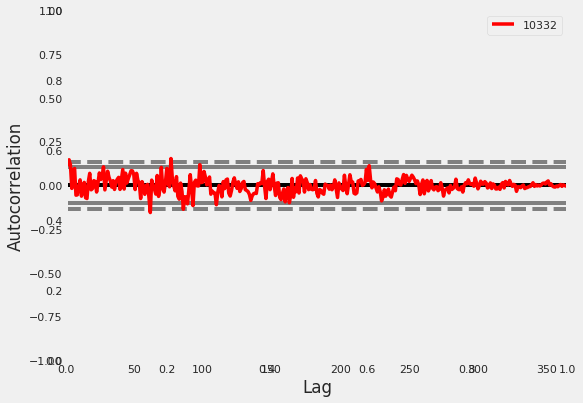

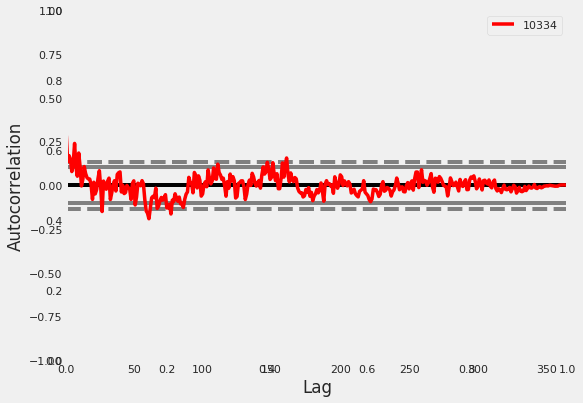

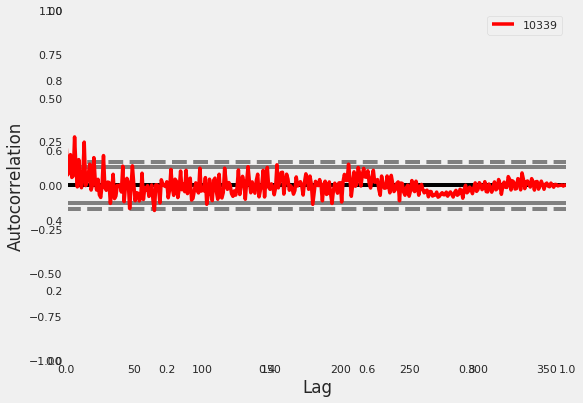

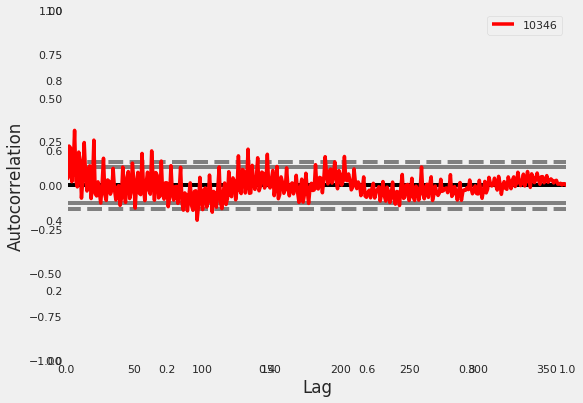

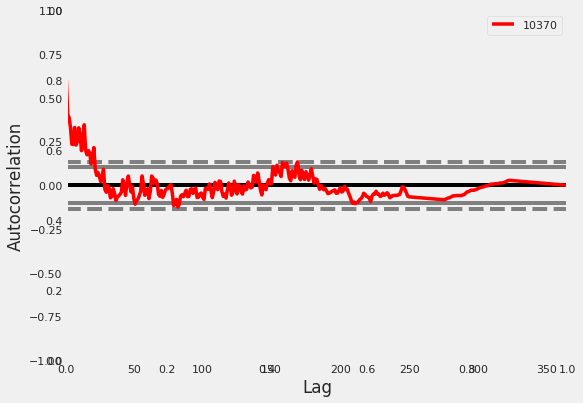

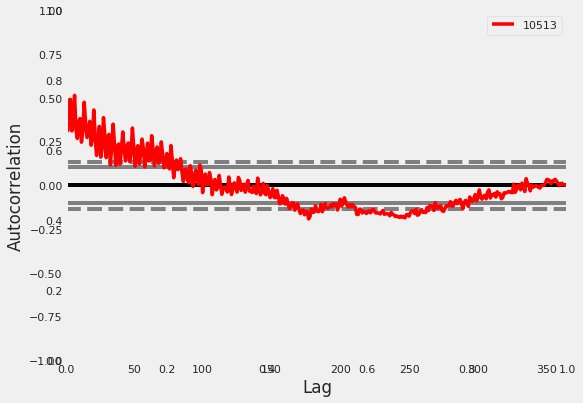

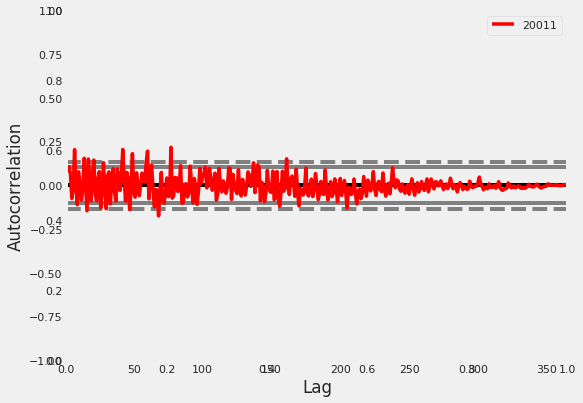

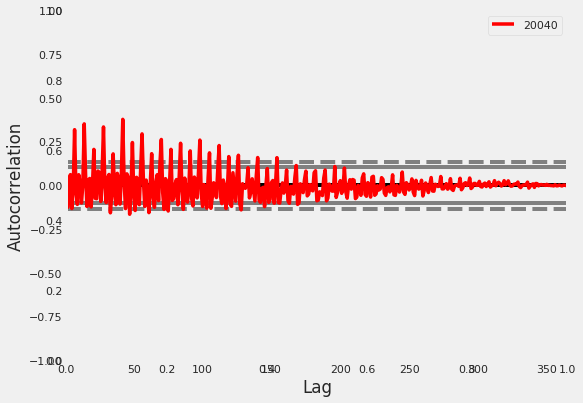

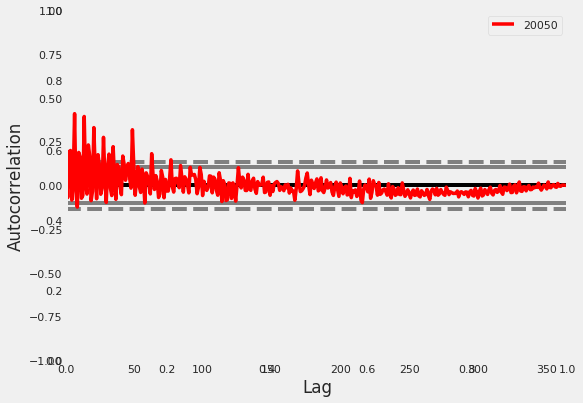

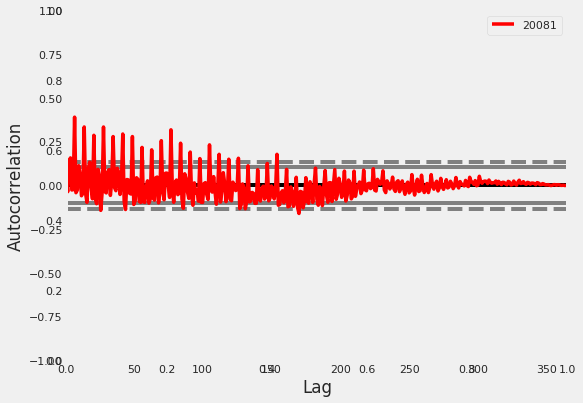

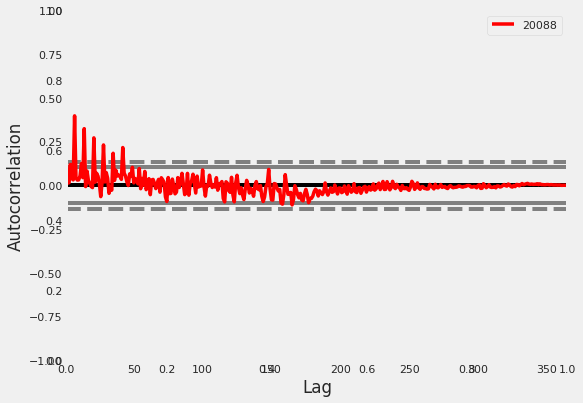

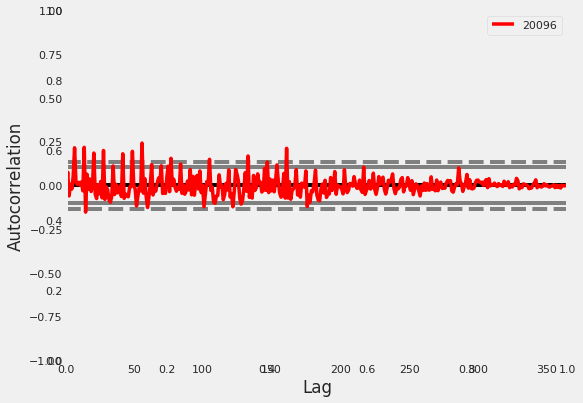

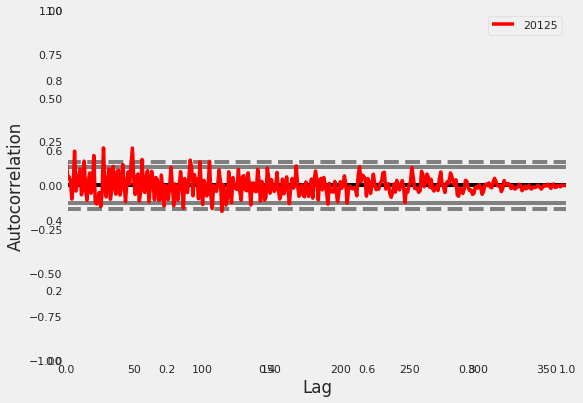

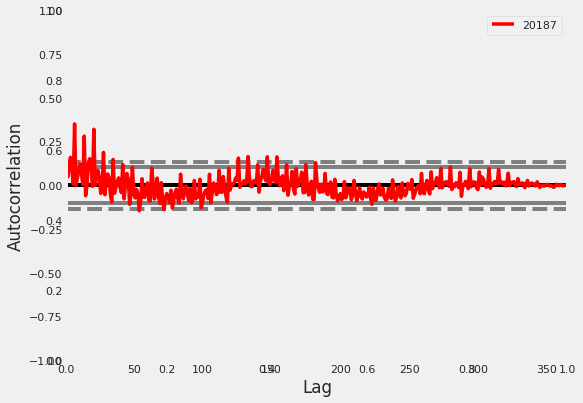

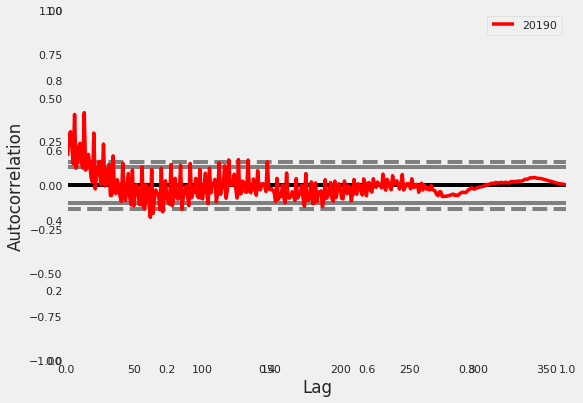

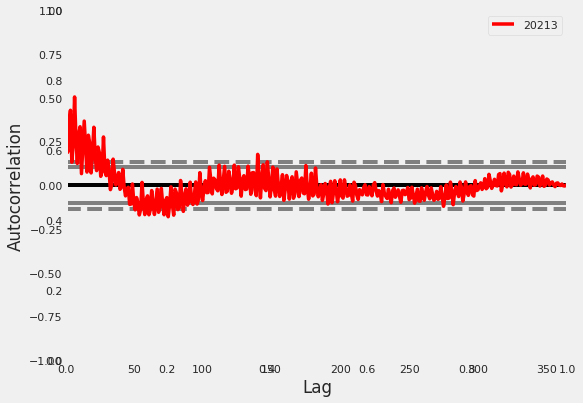

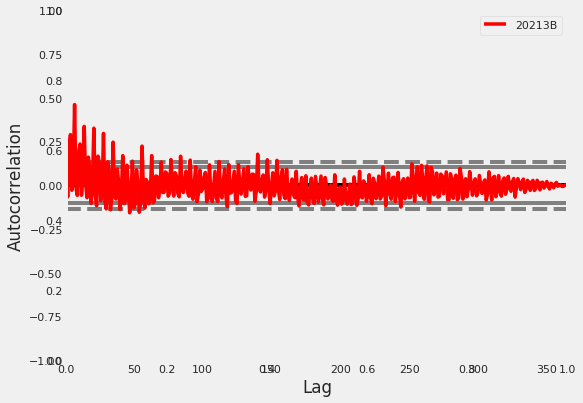

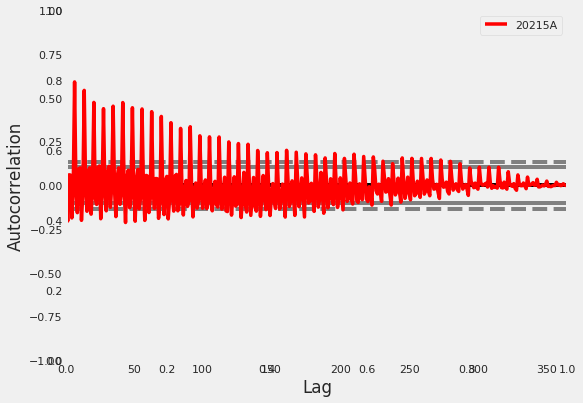

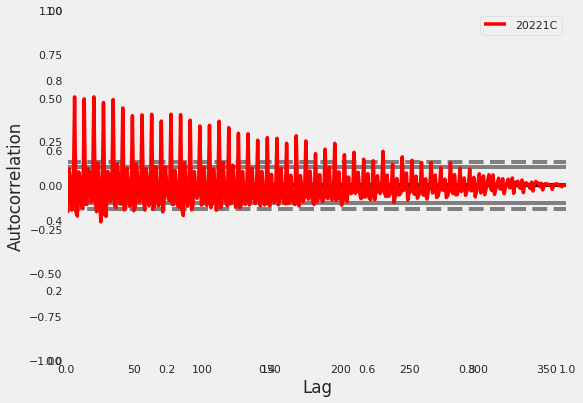

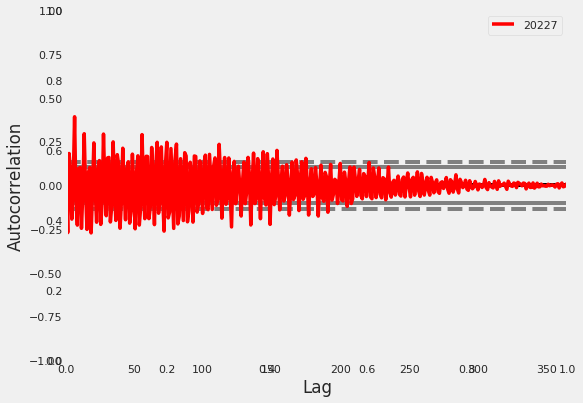

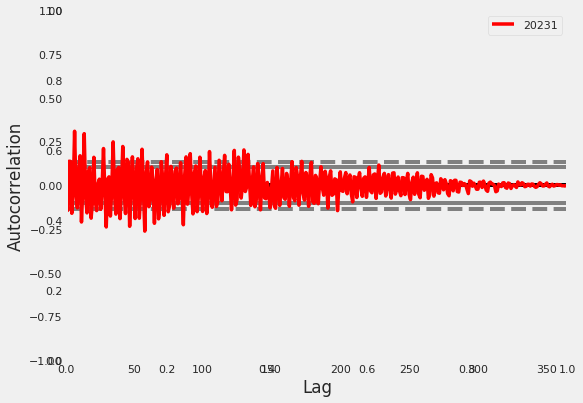

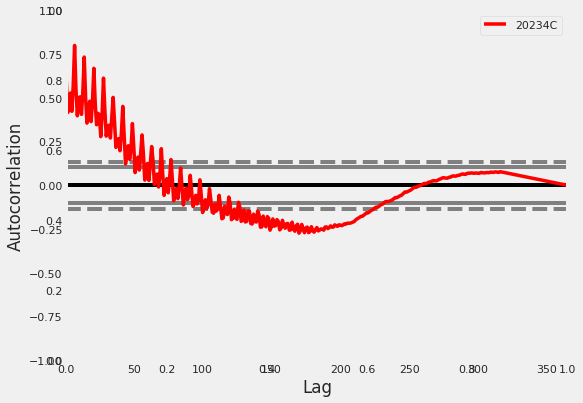

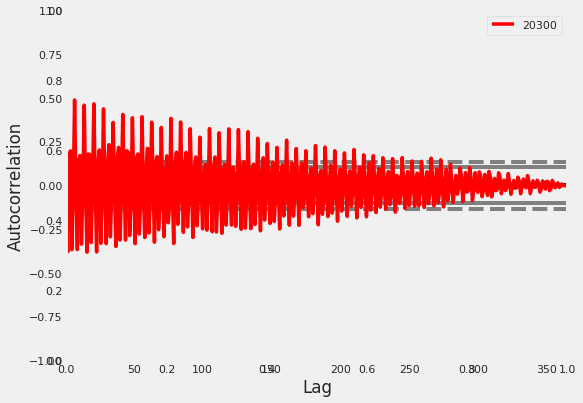

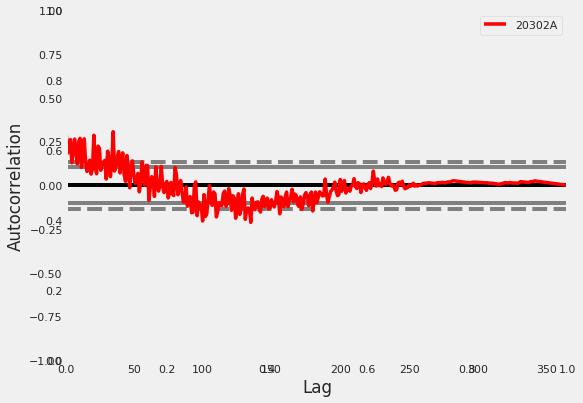

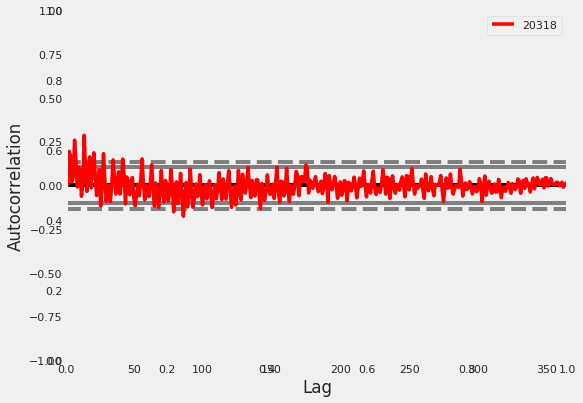

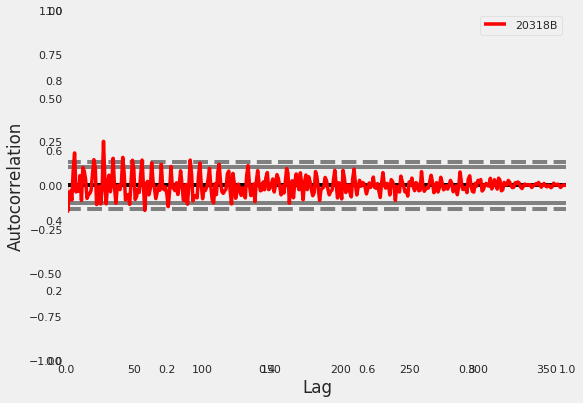

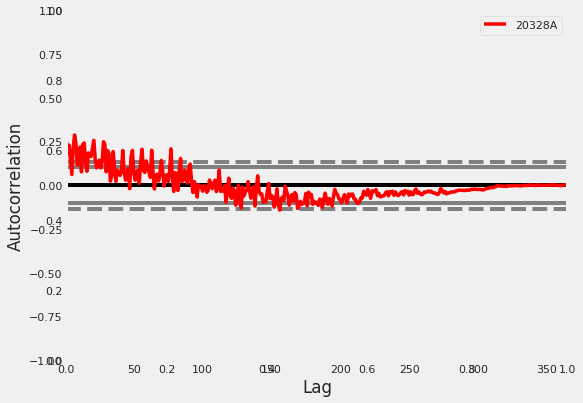

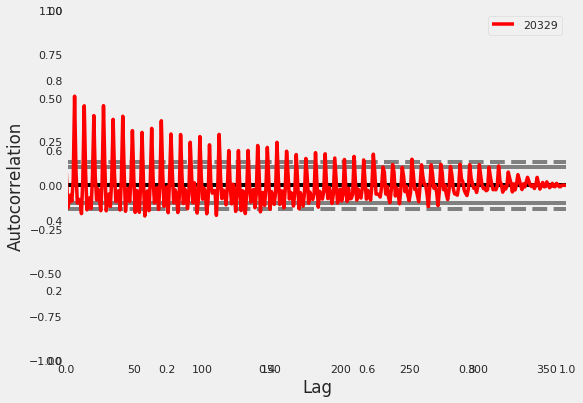

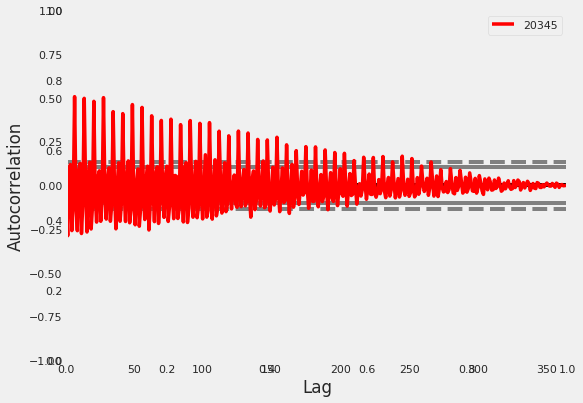

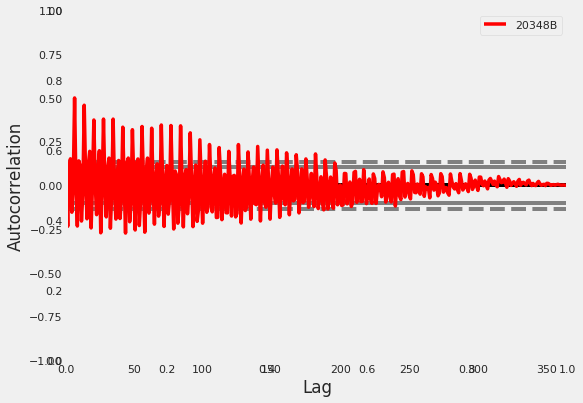

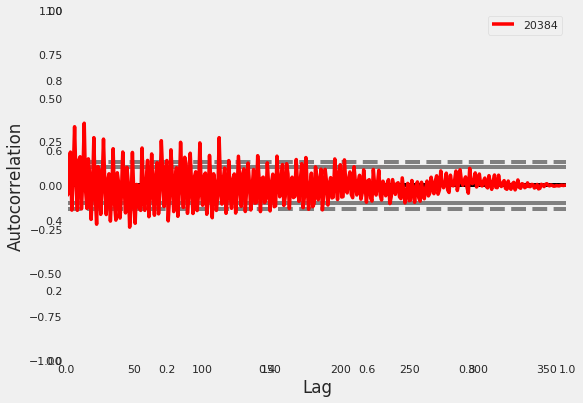

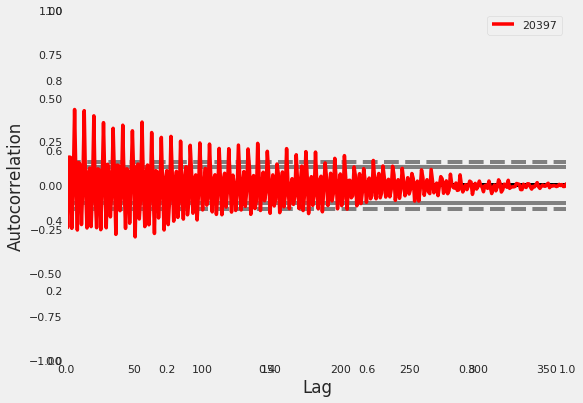

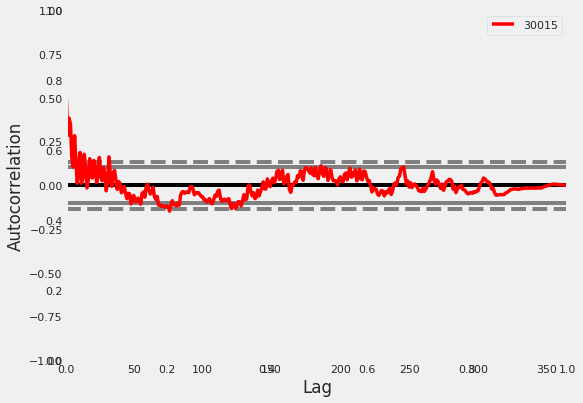

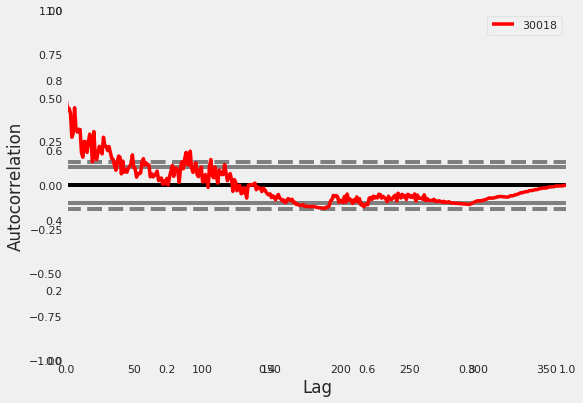

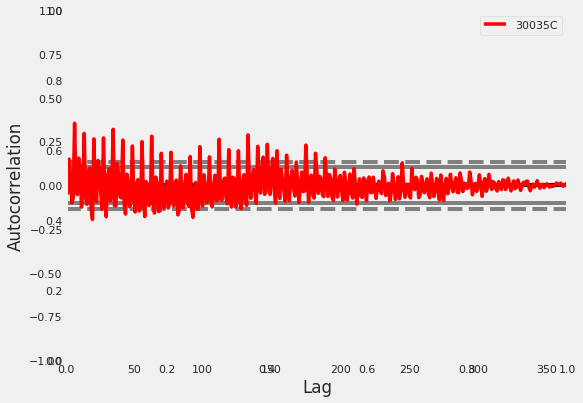

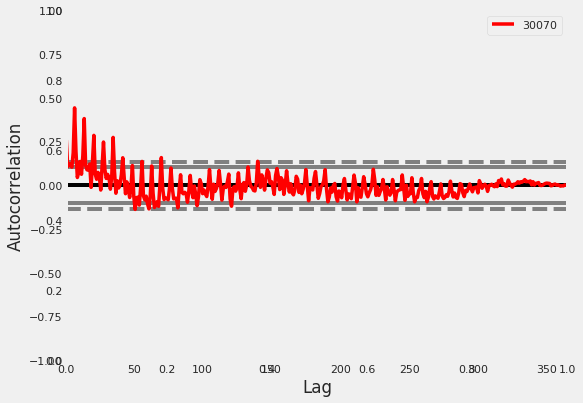

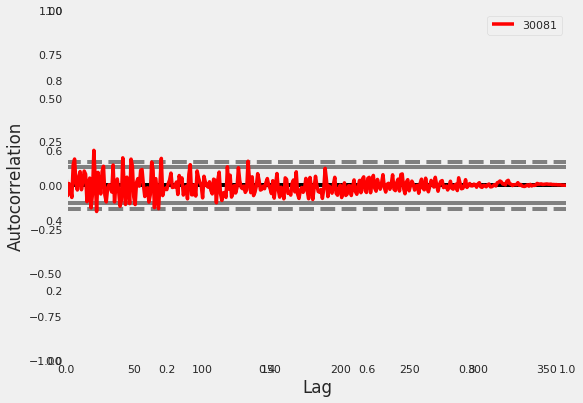

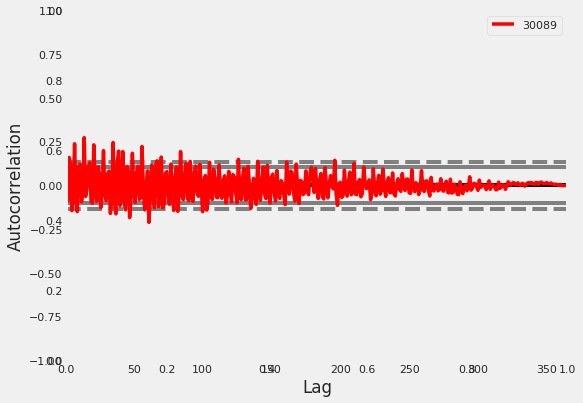

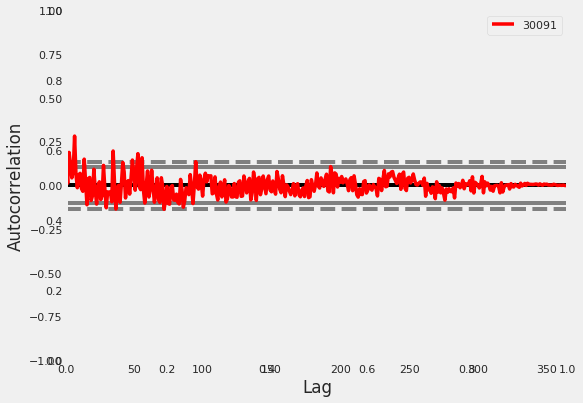

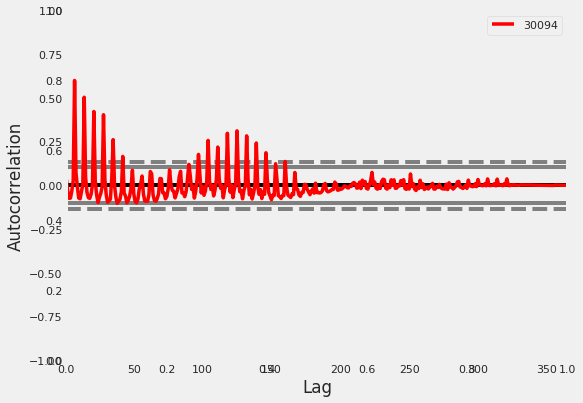

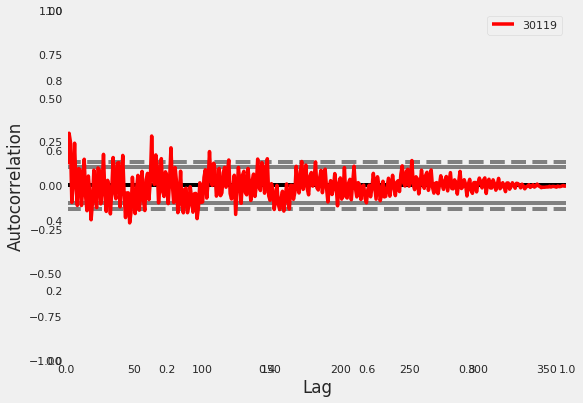

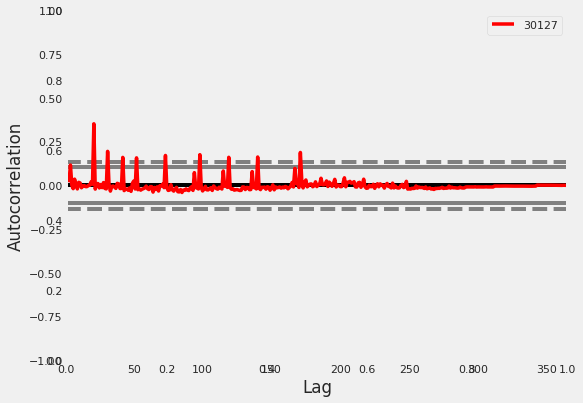

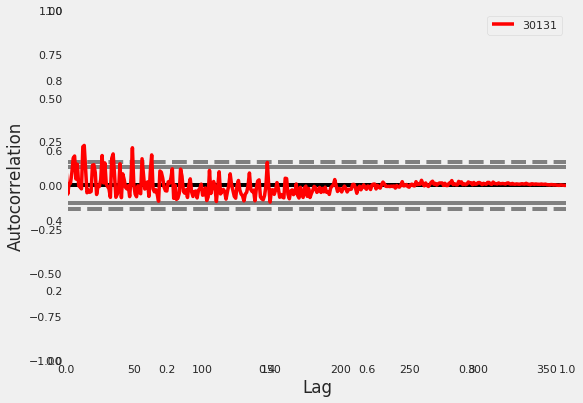

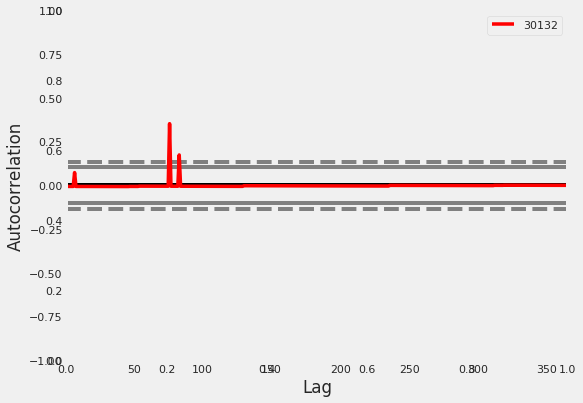

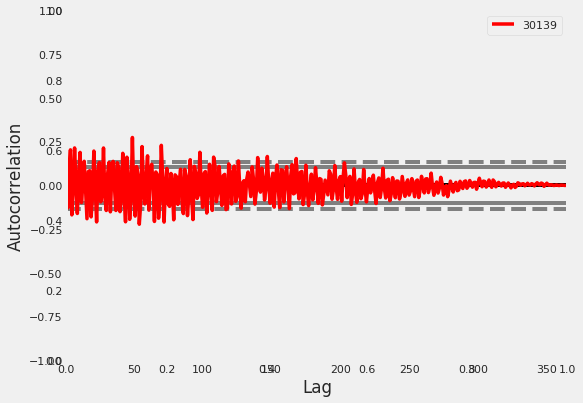

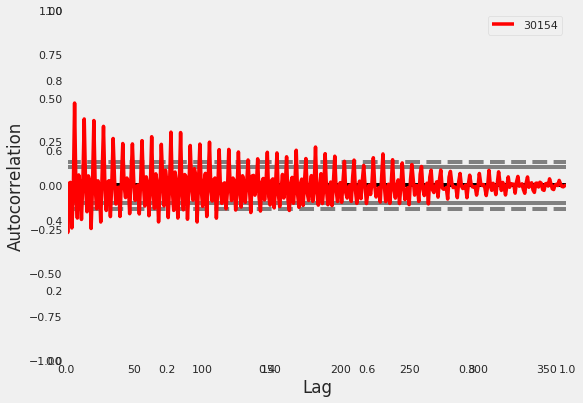

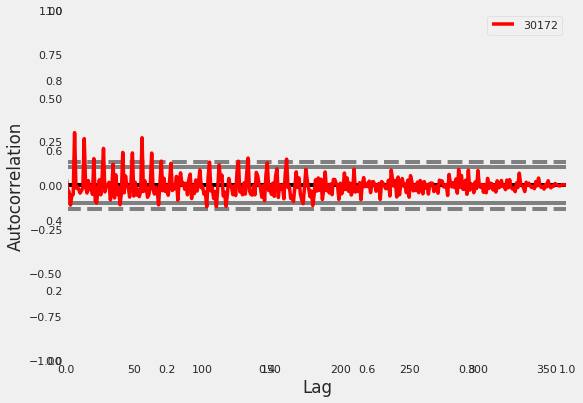

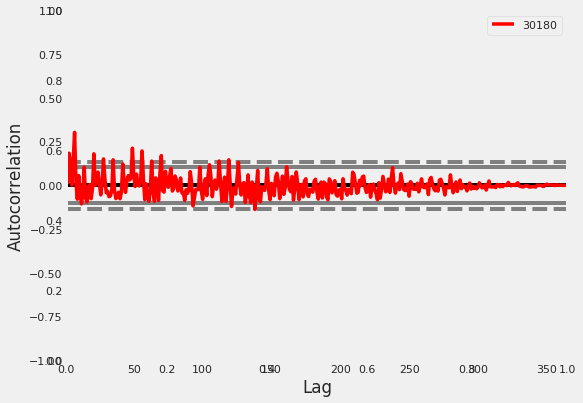

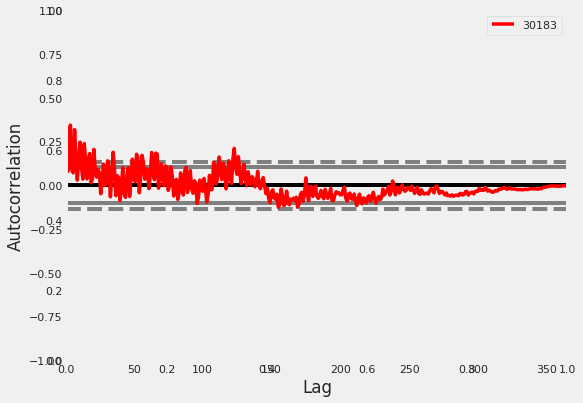

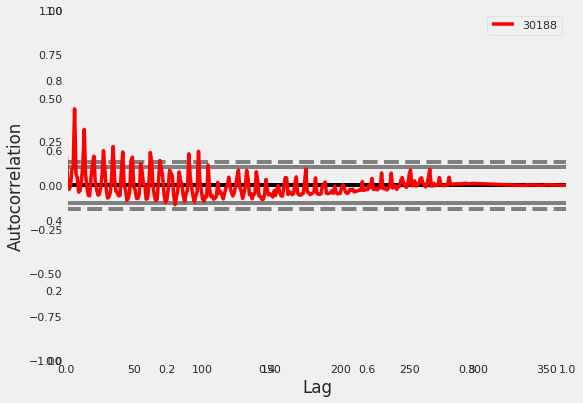

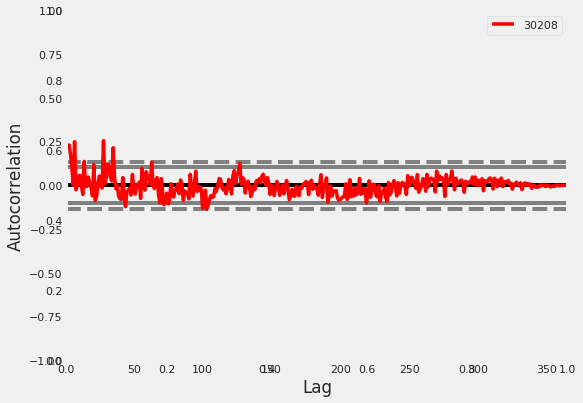

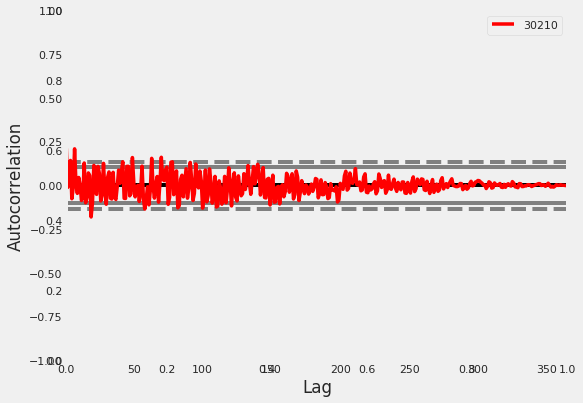

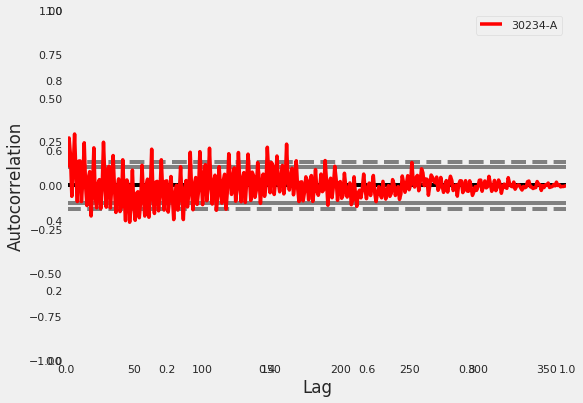

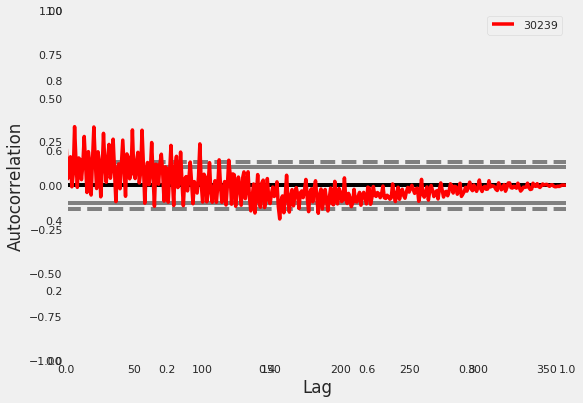

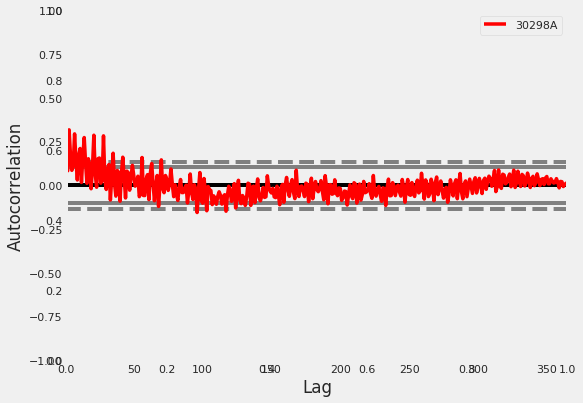

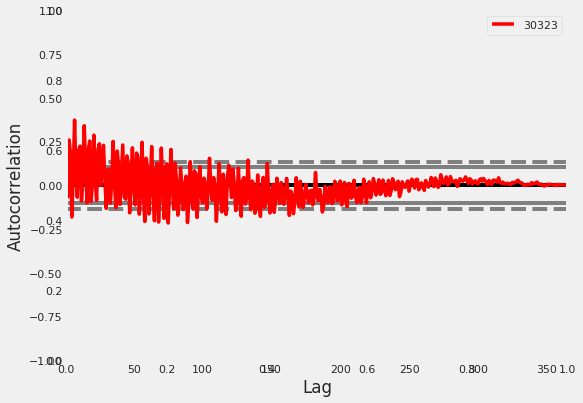

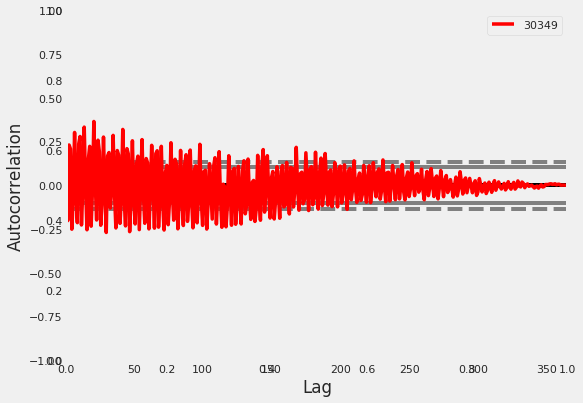

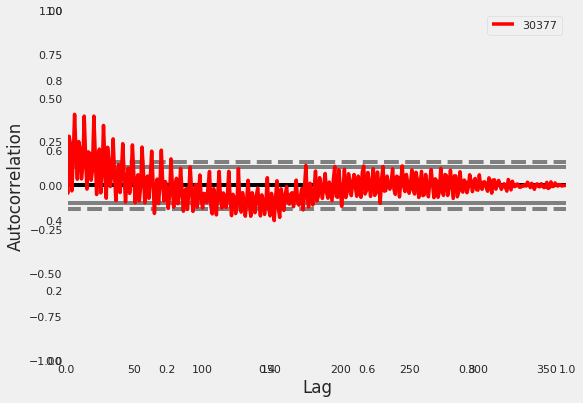

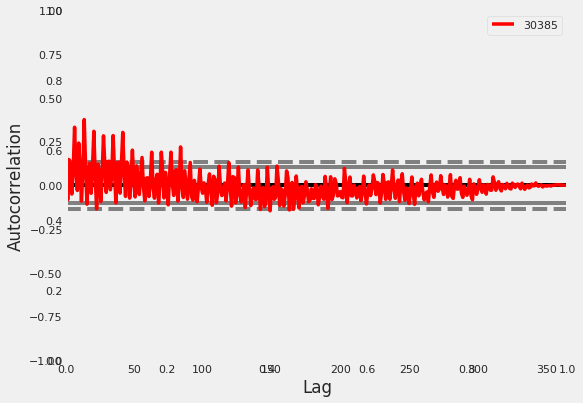

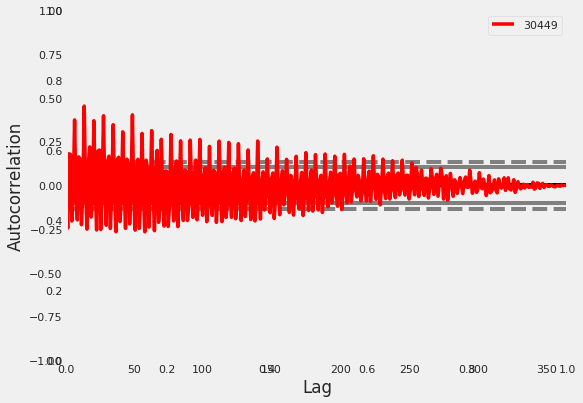

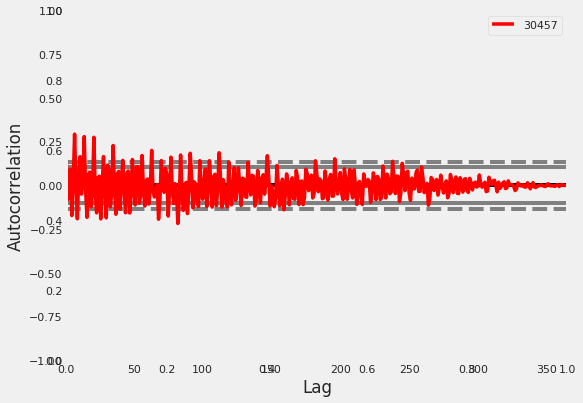

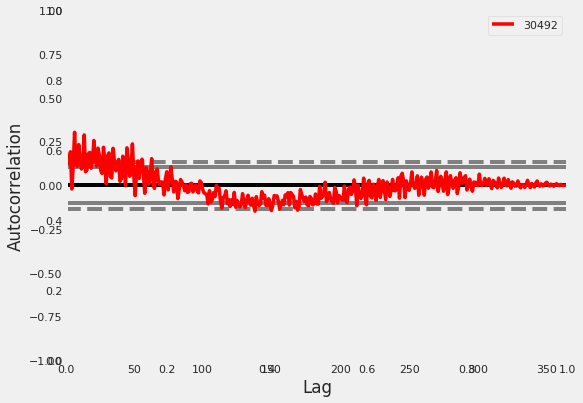

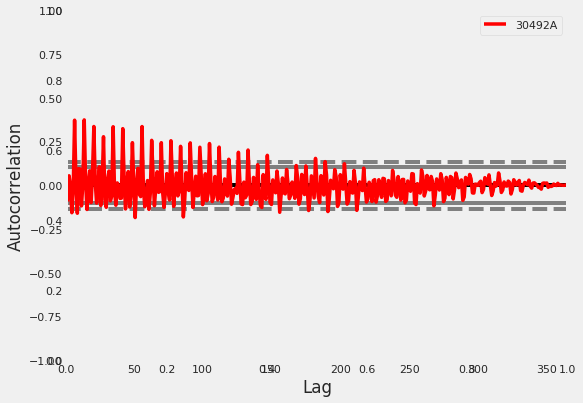

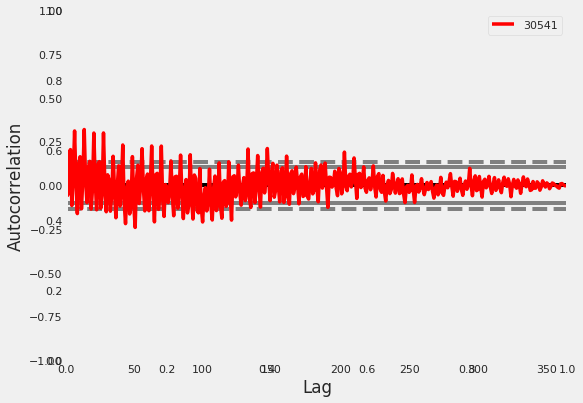

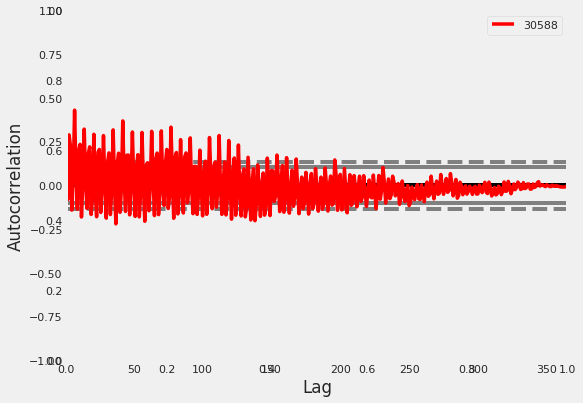

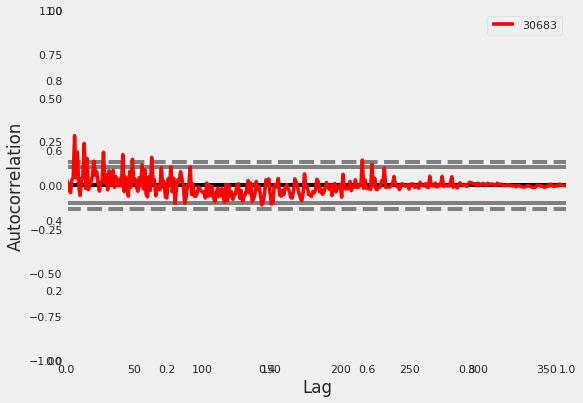

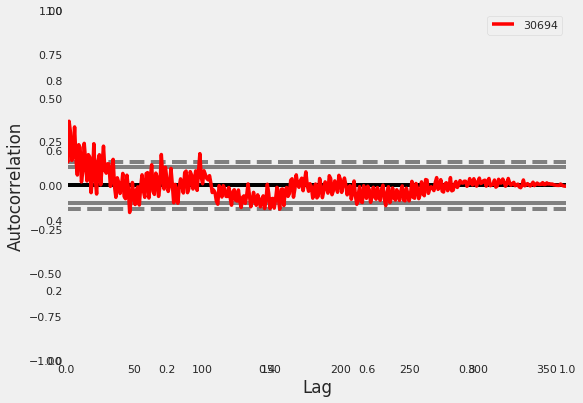

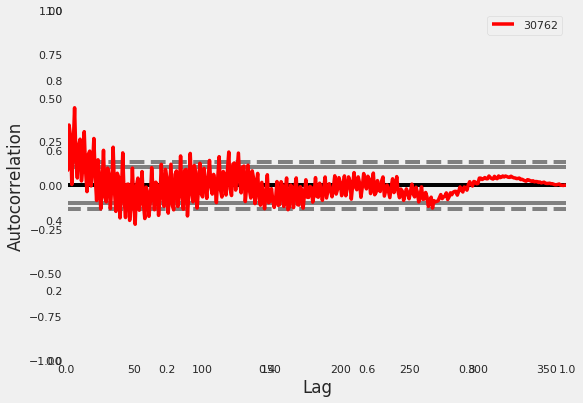

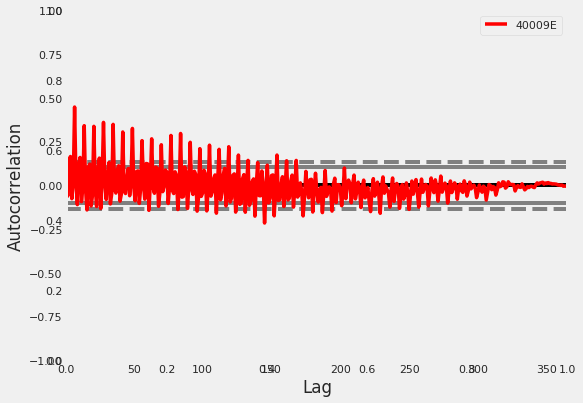

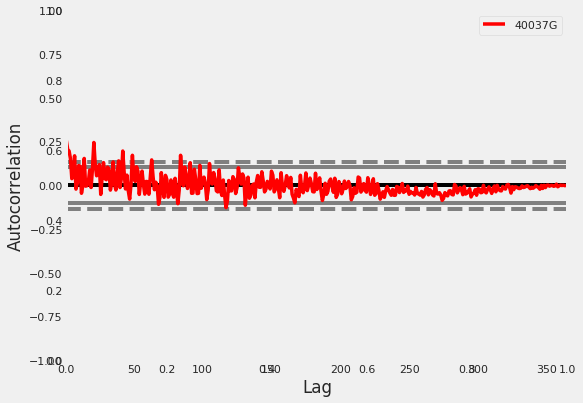

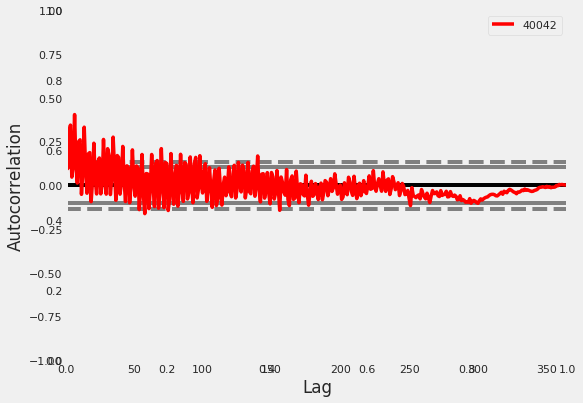

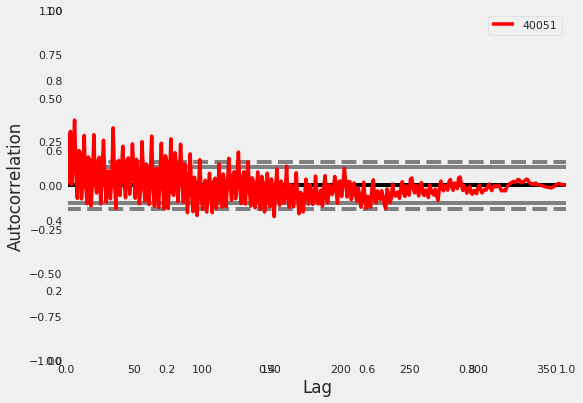

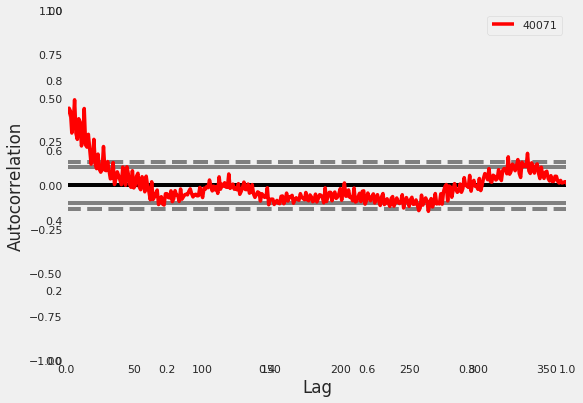

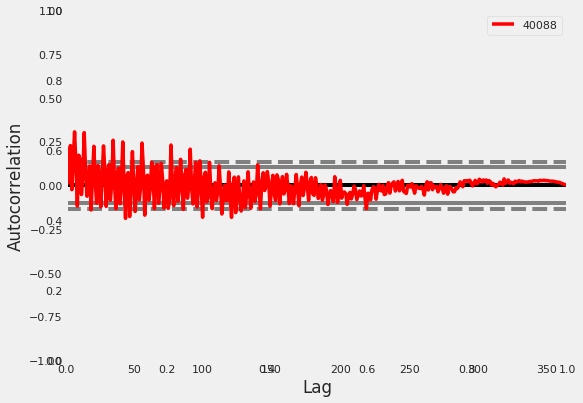

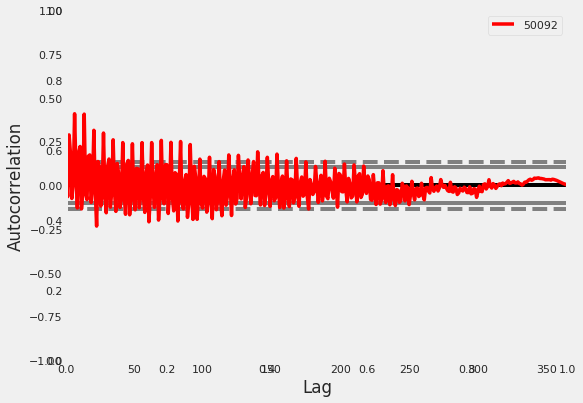

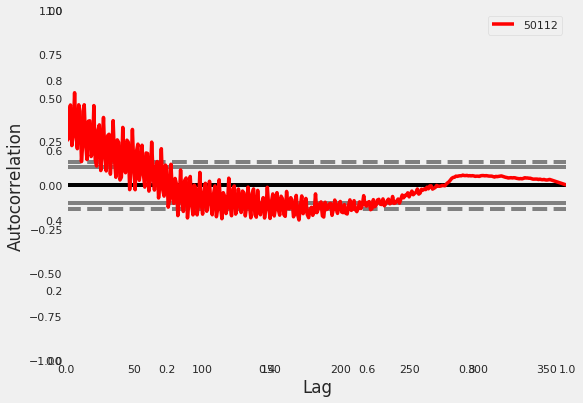

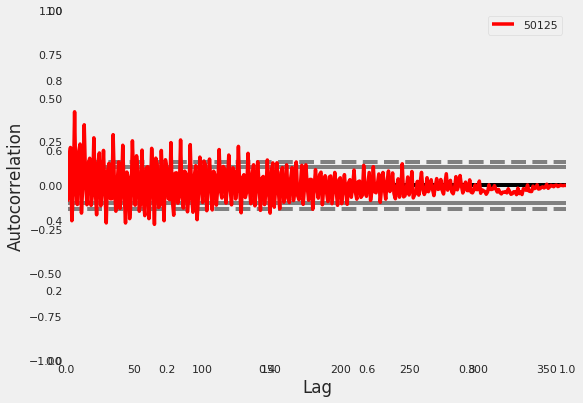

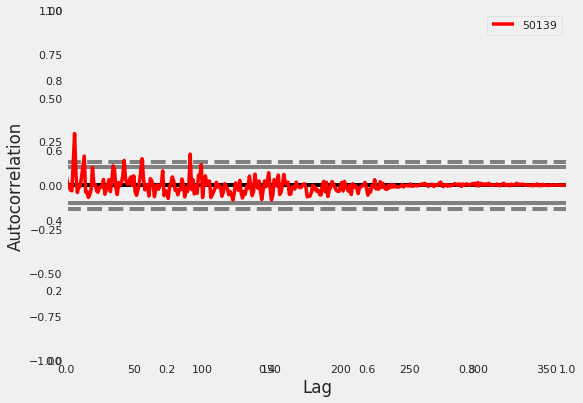

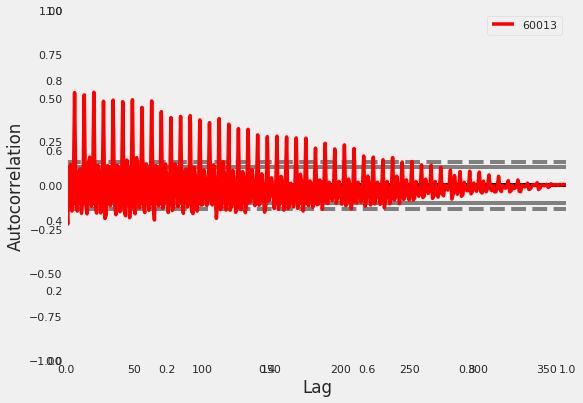

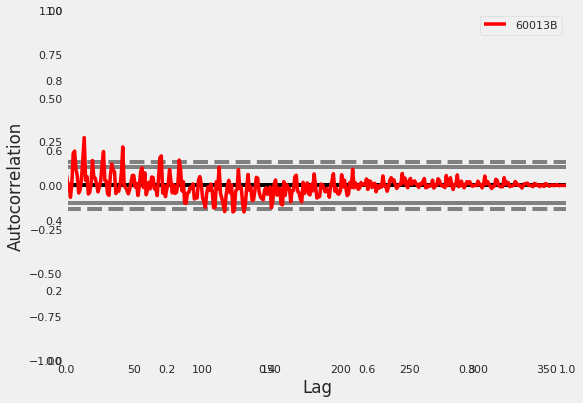

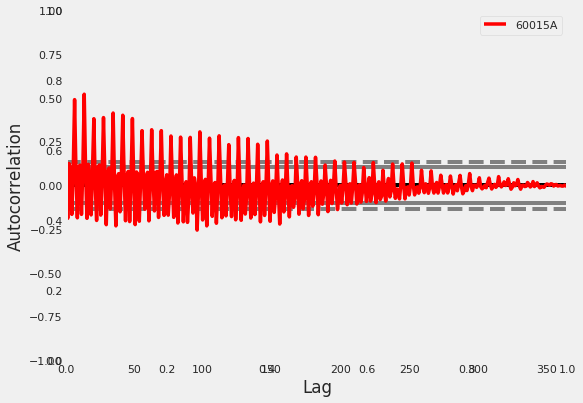

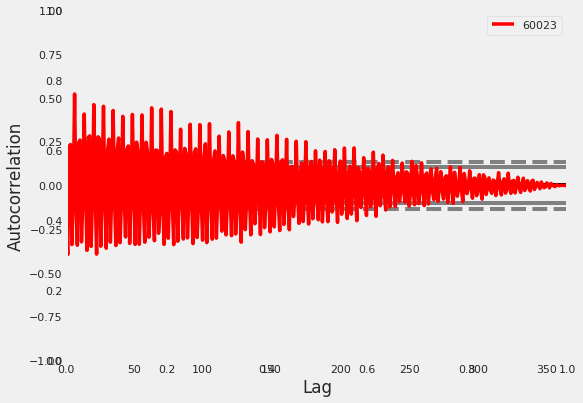

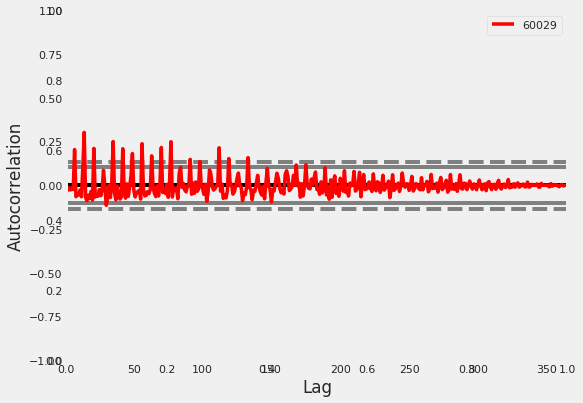

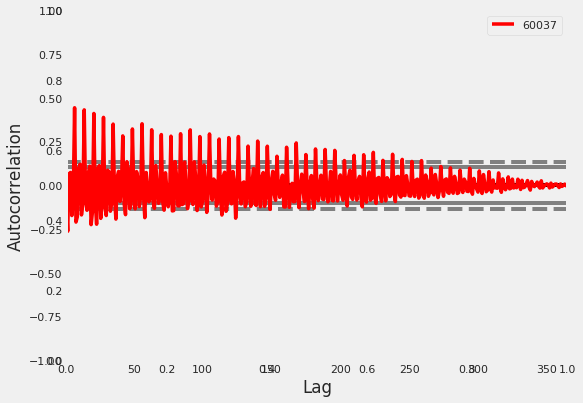

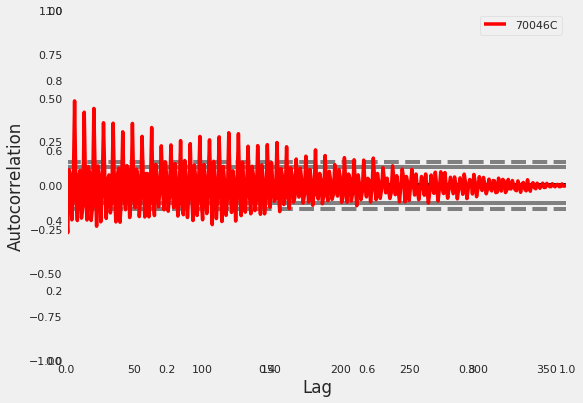

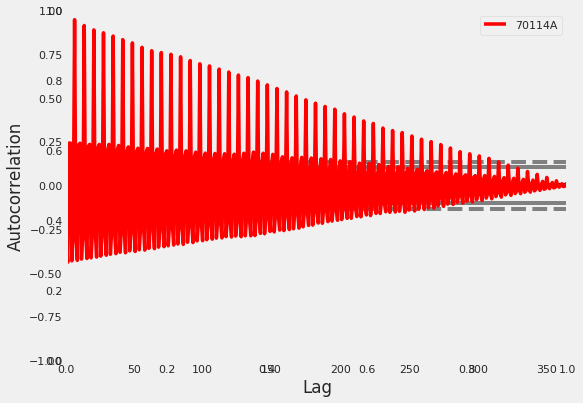

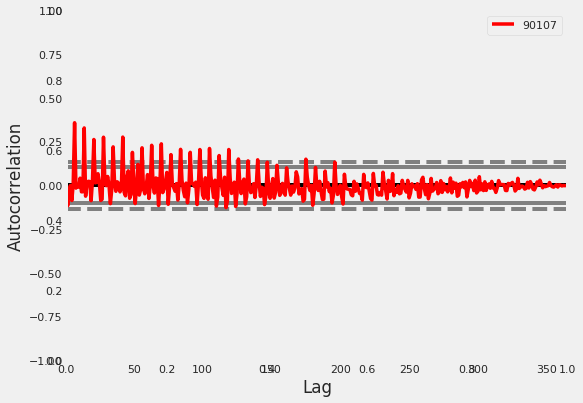

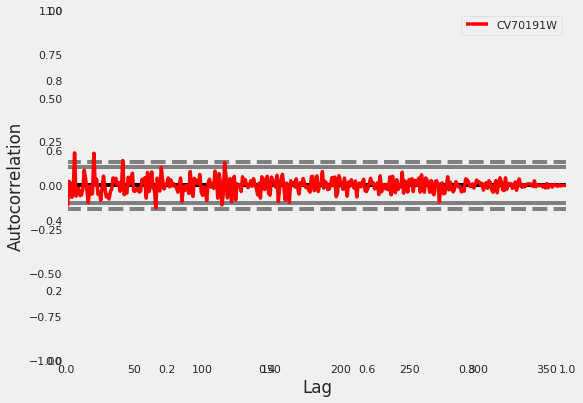

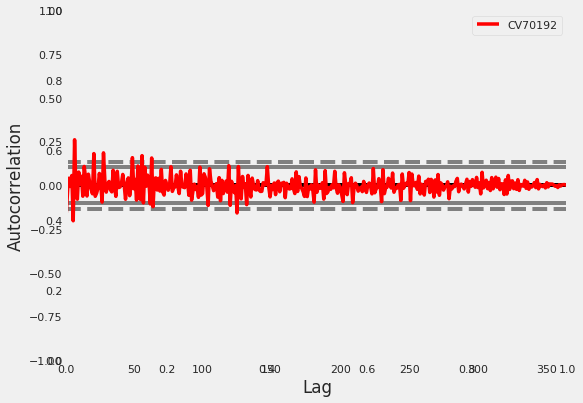

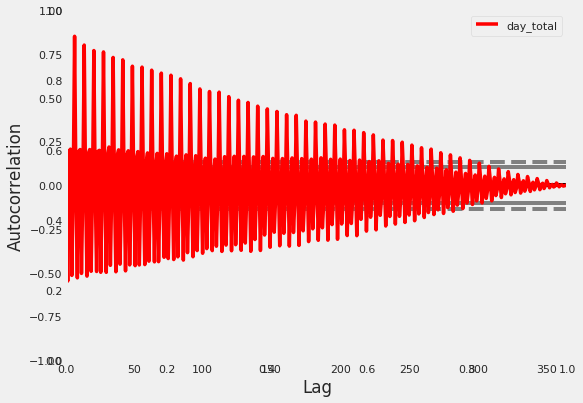

In [0]:
from pandas.plotting import autocorrelation_plot

#Regular data
print("\nCorrelogram of the Different Categories with Regular Data = Red\n")
for col in dfqty.columns:
  plt.subplots(1, figsize=(8,6))
  autocorrelation_plot(dfqty[col], label= col, linewidth=3.5, color='red')
  plt.legend()

# #Differenced data
# print("\nCorrelogram of the Different Categories with Differenced Data = Red\n")
# for col in diff.columns:
#   plt.subplots(1, figsize=(8,6))
#   autocorrelation_plot(diff[col], label= col, linewidth=3.5, color='red')
#   plt.legend()



ACL Plot for Regular Data



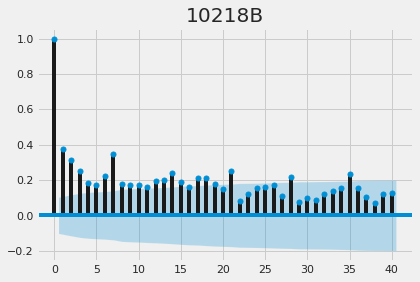

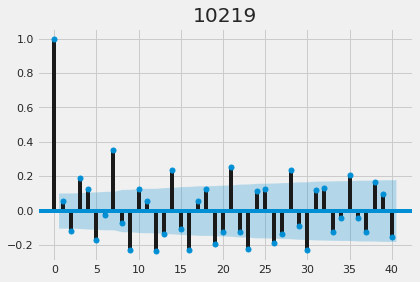

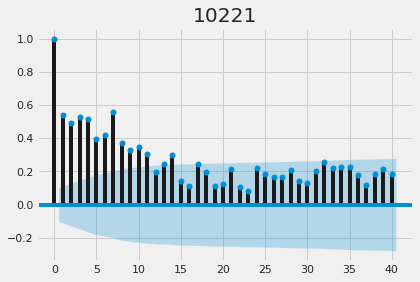

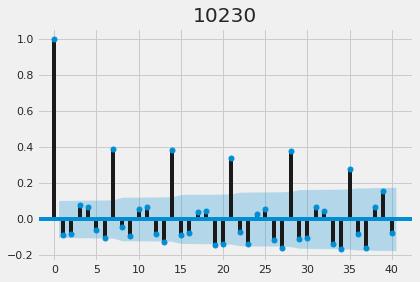

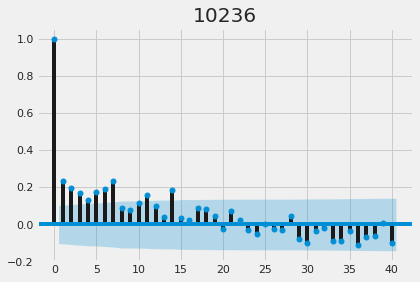

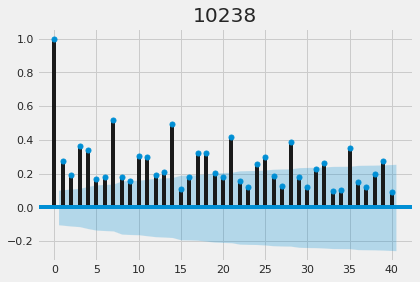

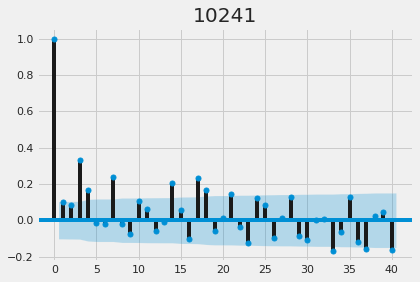

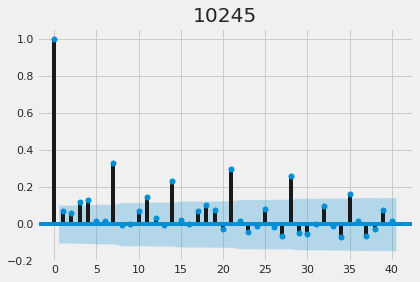

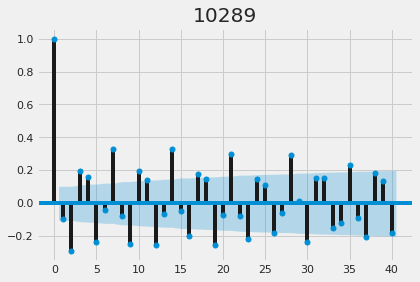

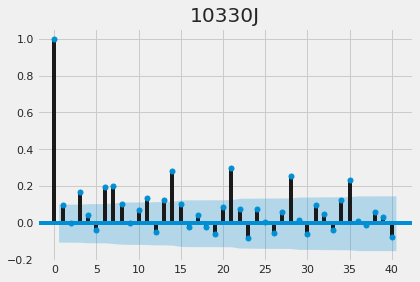

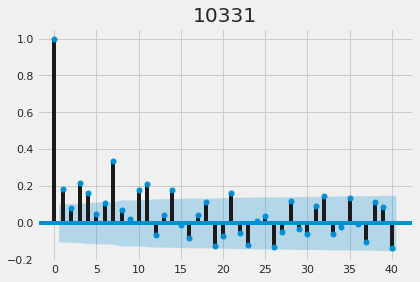

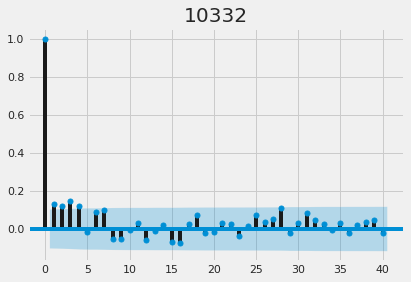

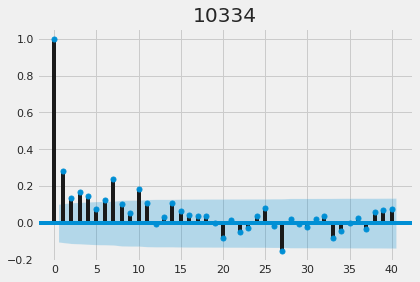

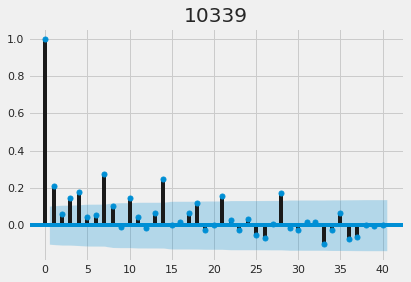

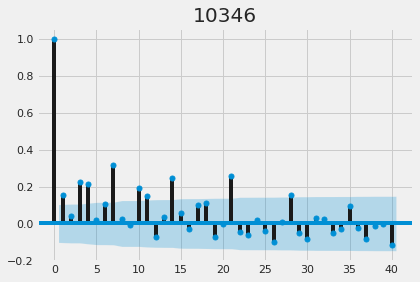

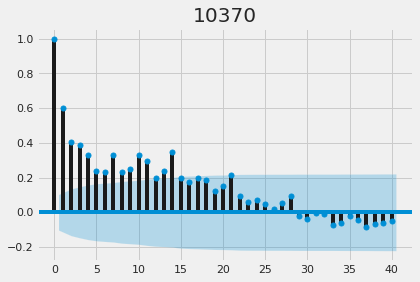

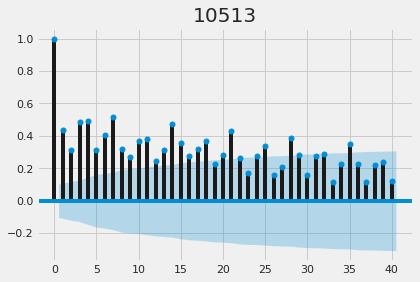

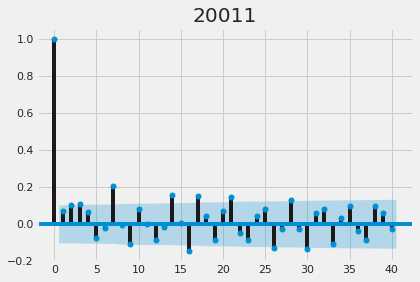

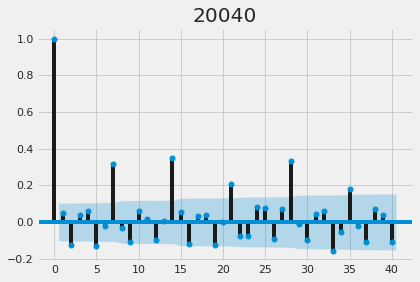

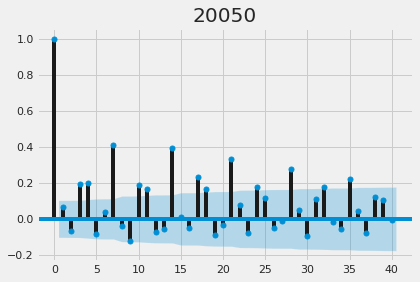

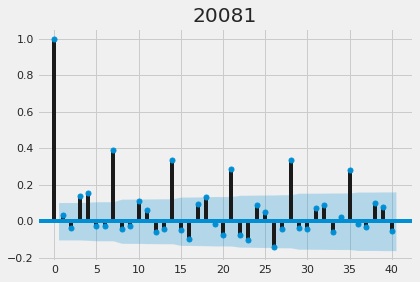

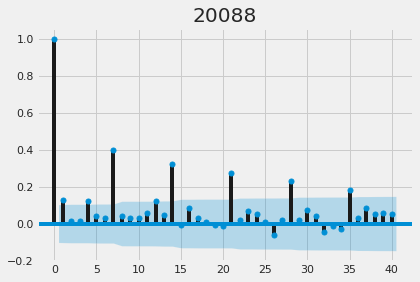

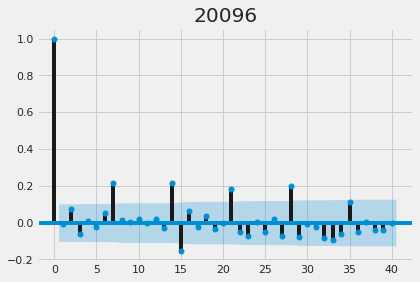

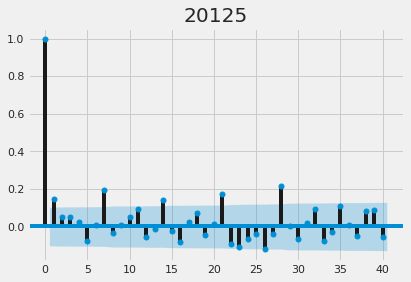

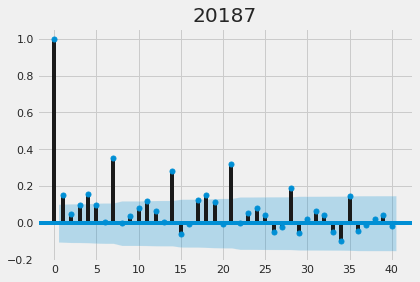

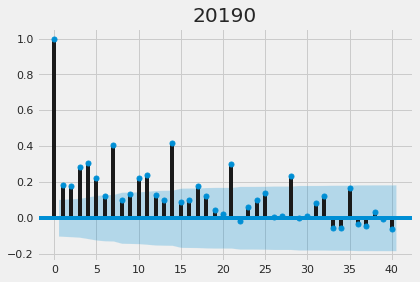

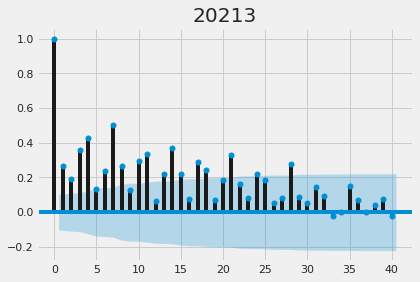

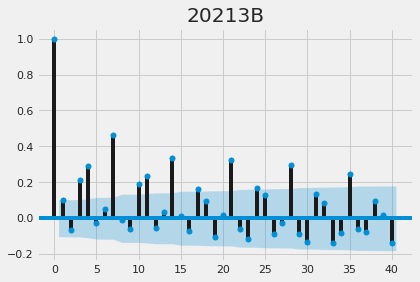

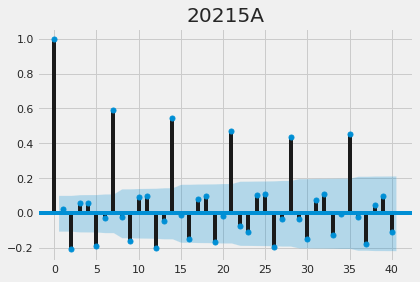

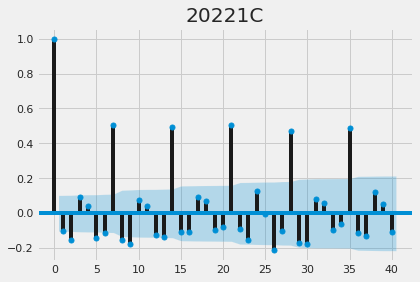

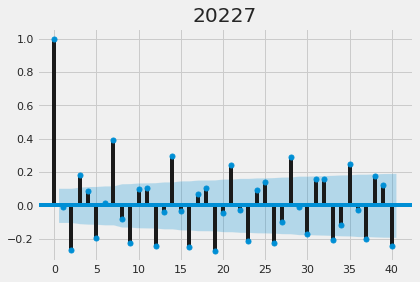

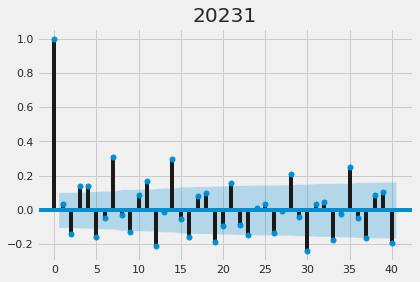

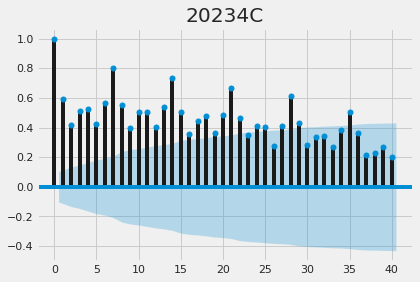

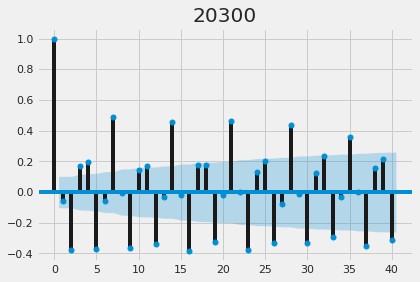

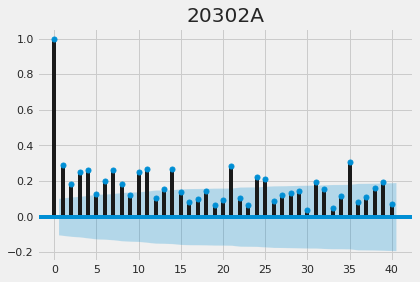

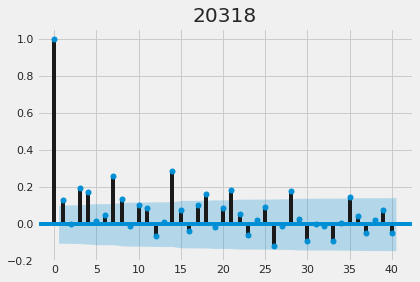

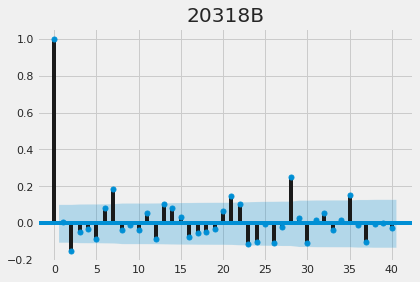

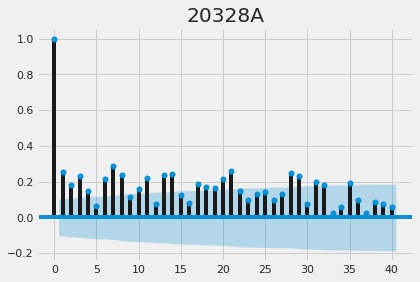

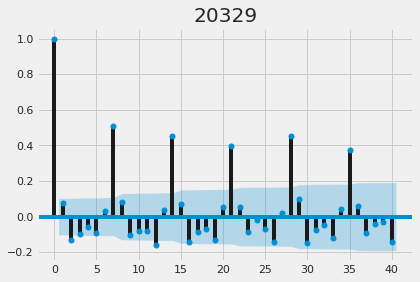

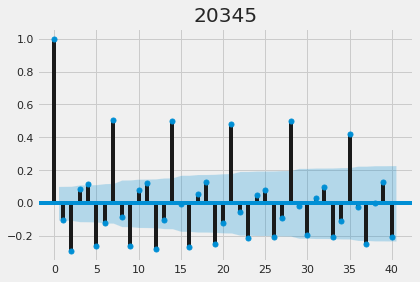

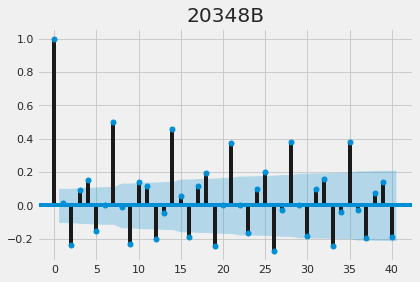

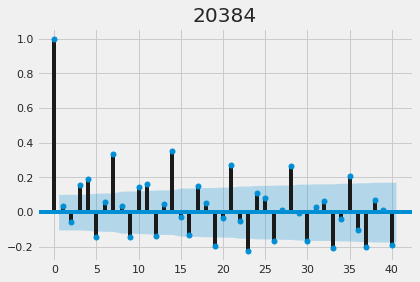

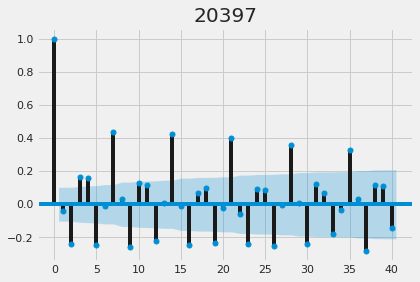

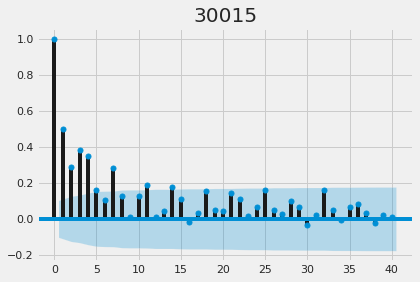

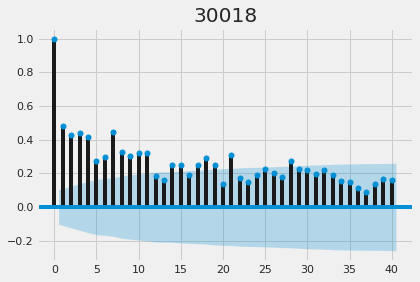

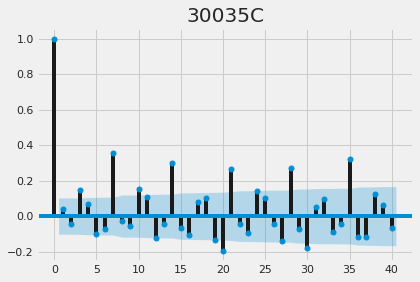

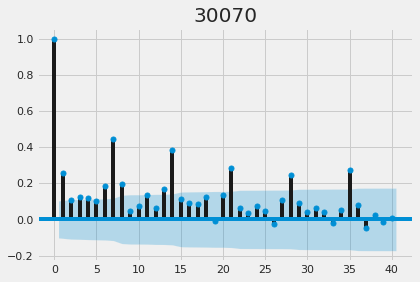

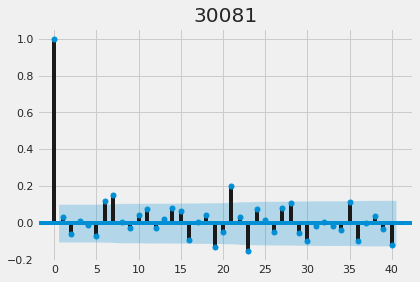

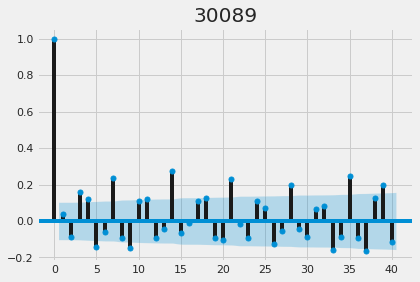

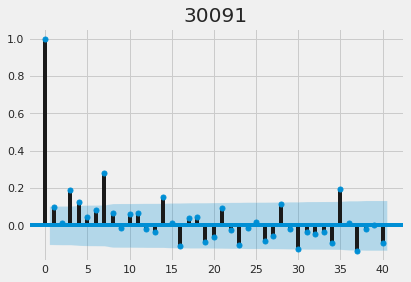

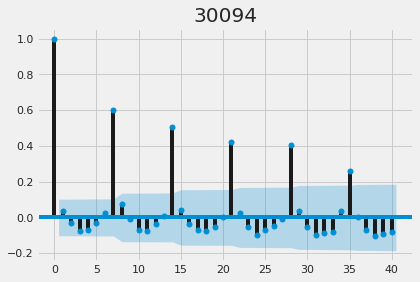

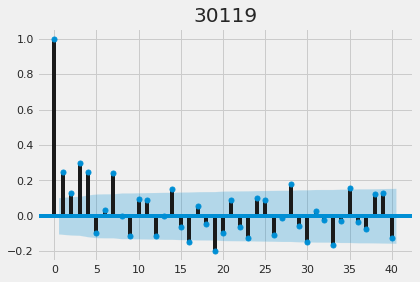

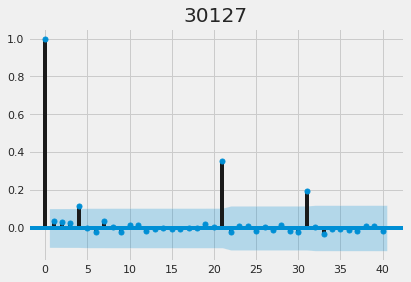

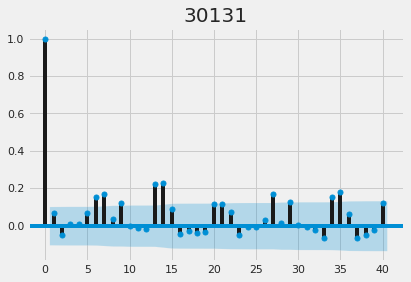

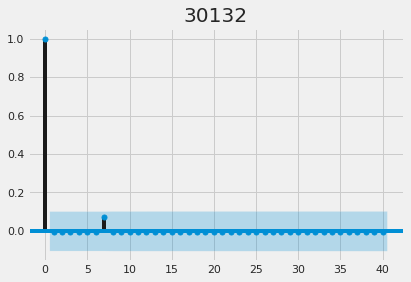

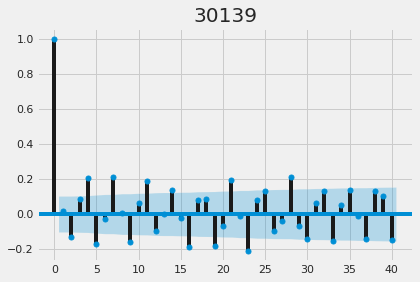

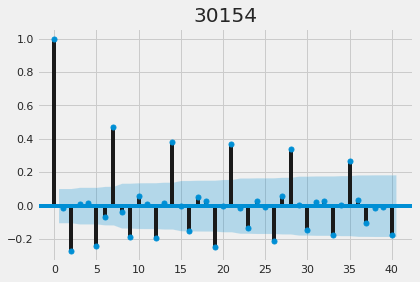

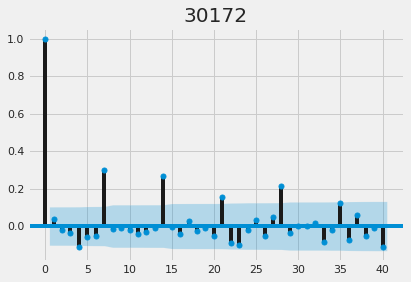

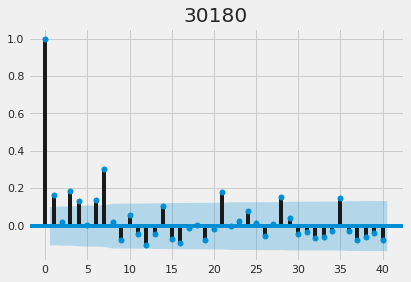

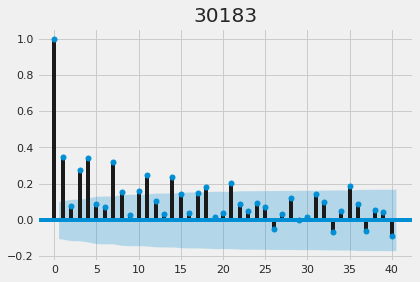

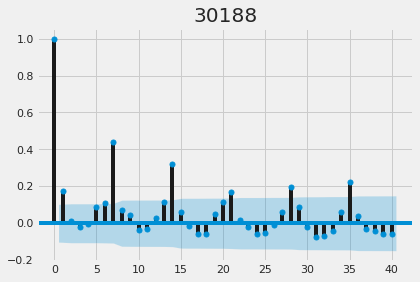

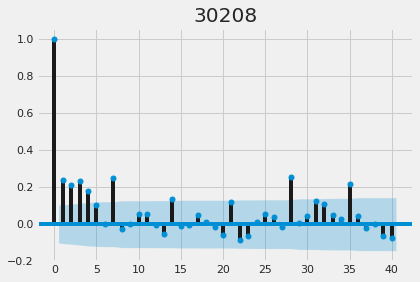

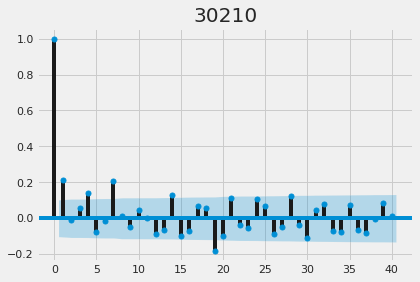

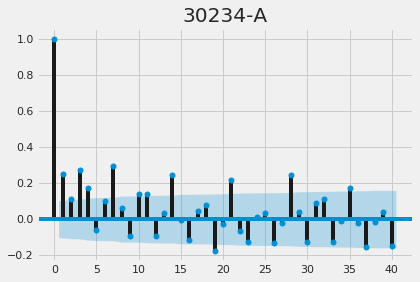

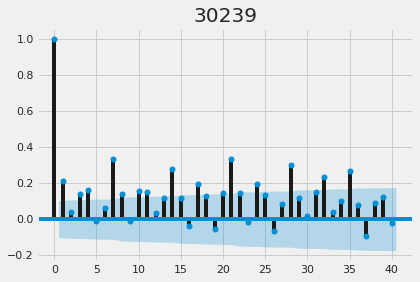

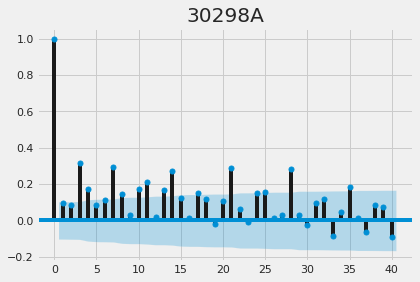

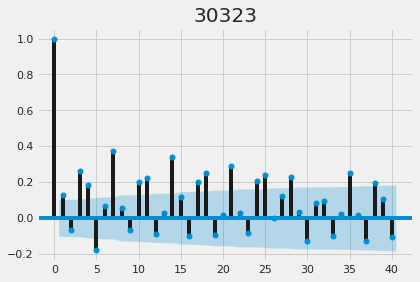

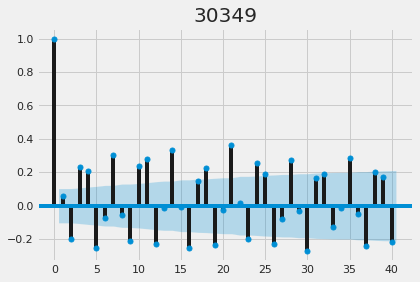

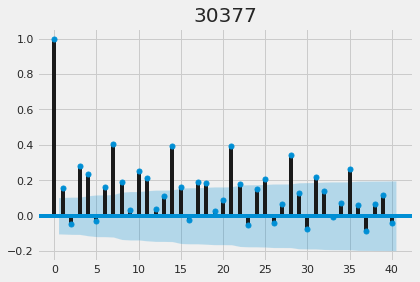

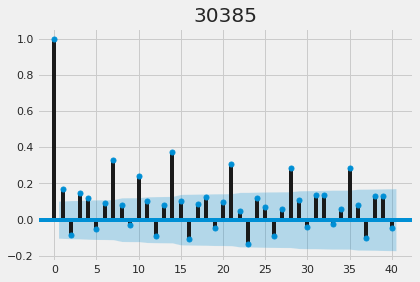

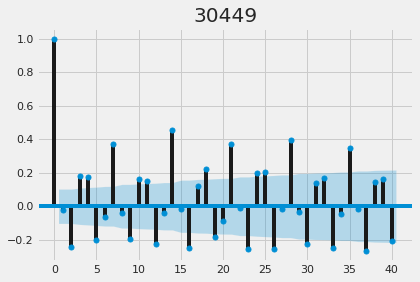

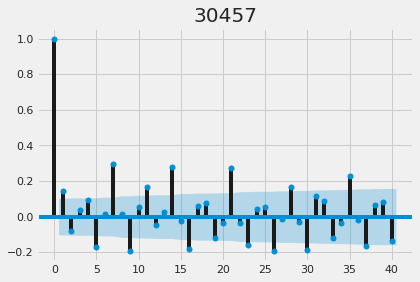

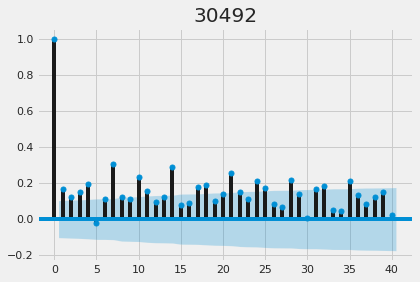

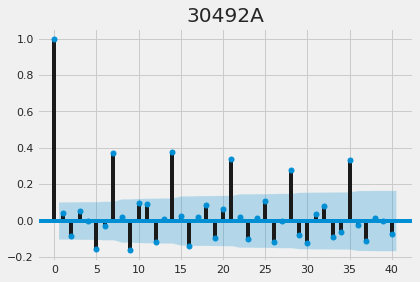

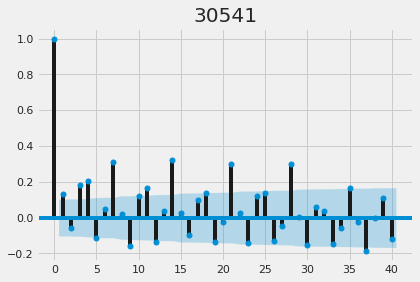

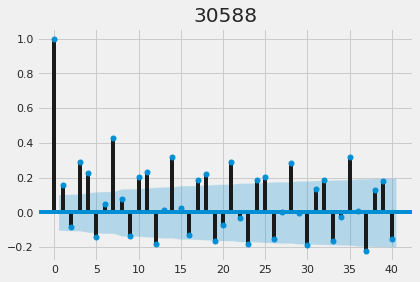

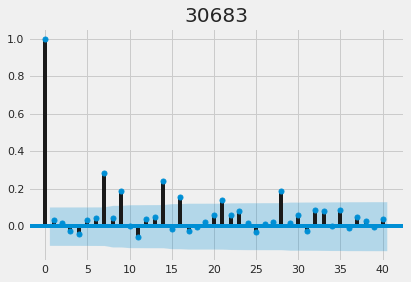

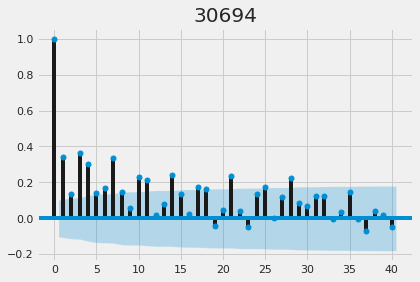

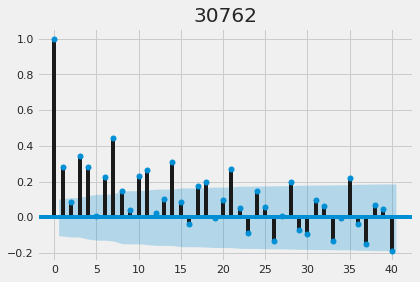

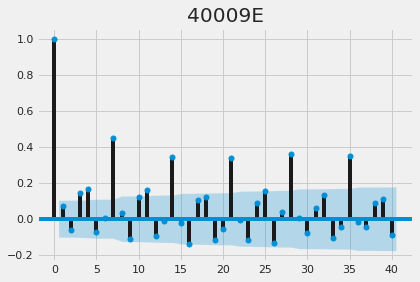

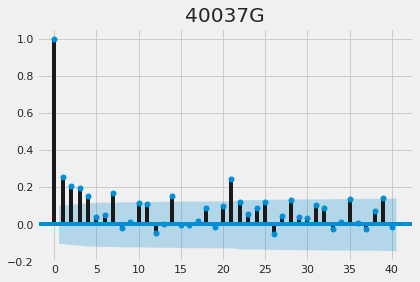

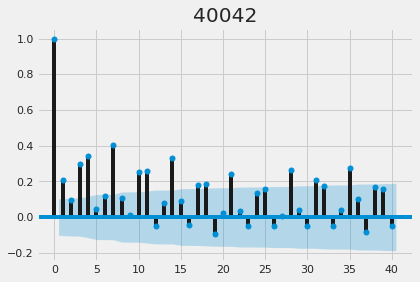

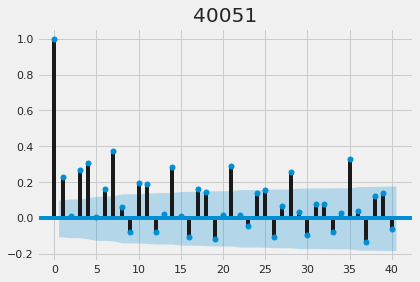

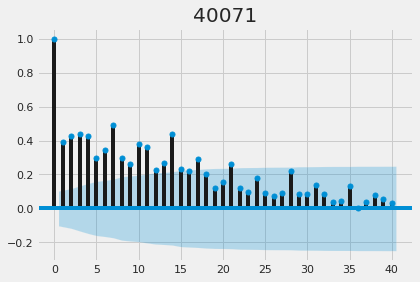

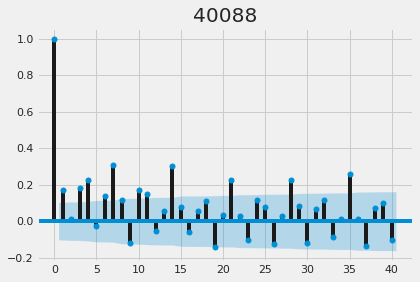

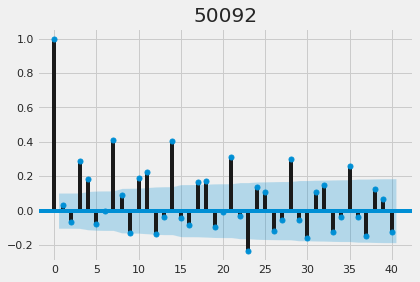

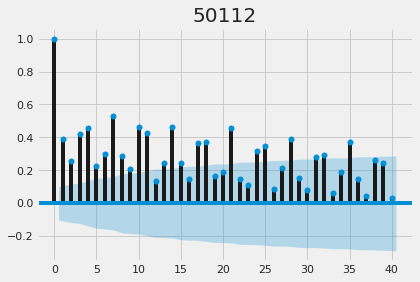

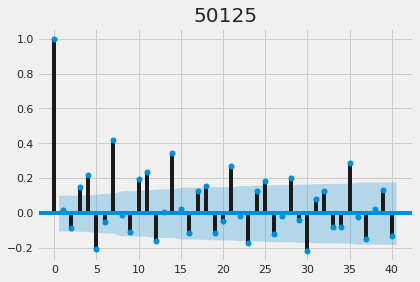

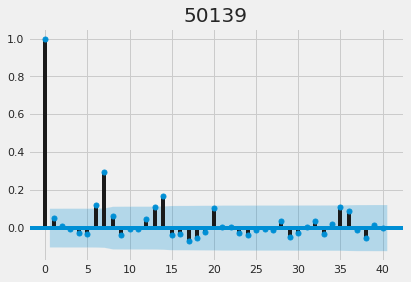

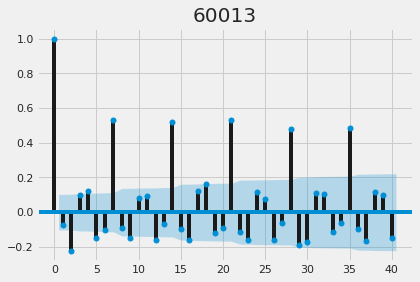

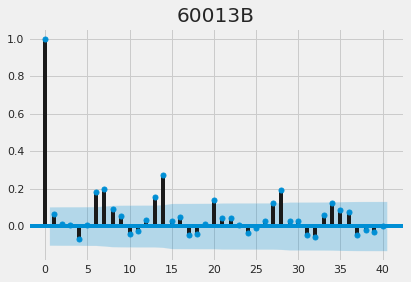

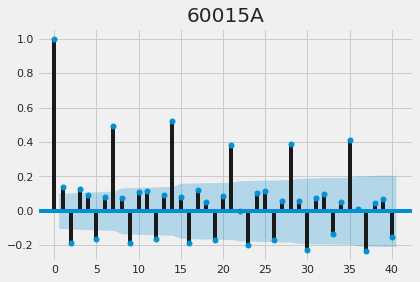

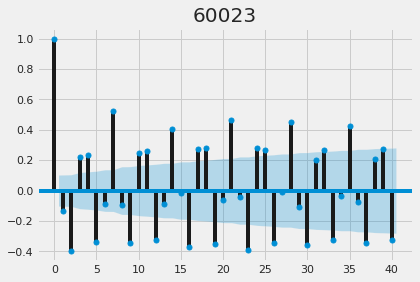

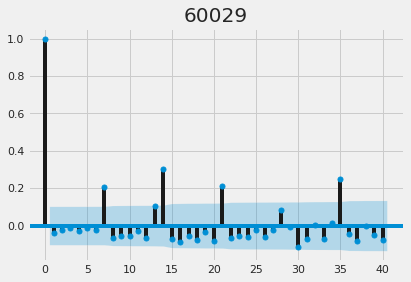

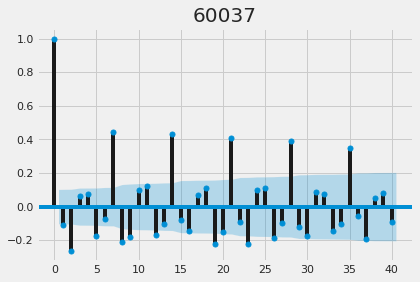

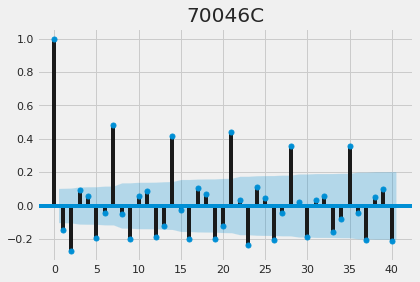

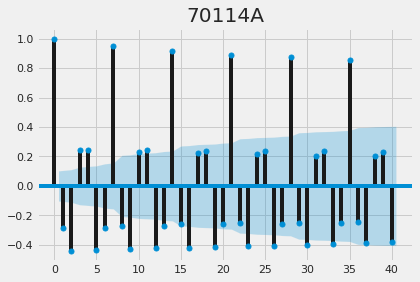

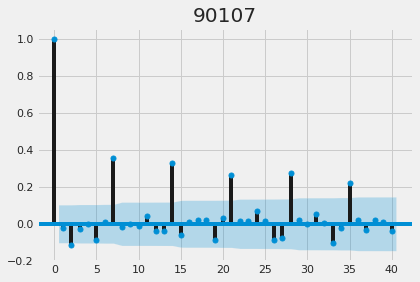

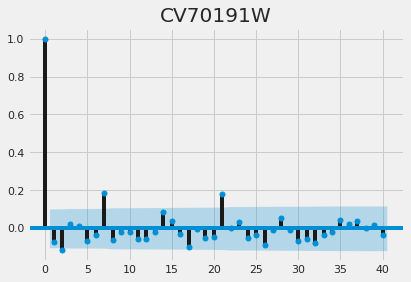

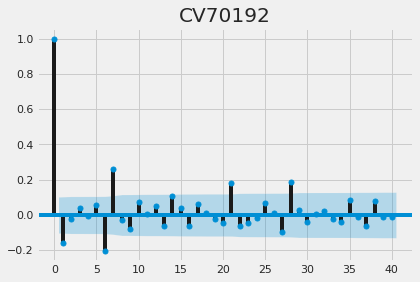

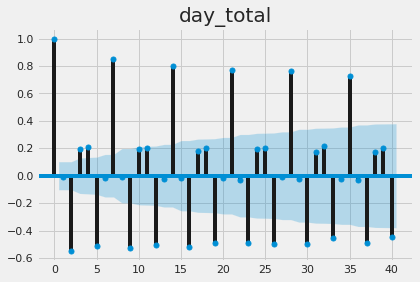

In [0]:
#Plotting the non-stationary data

print ("ACL Plot for Regular Data\n")
for col in dfqty.columns:
  sm.graphics.tsa.plot_acf(dfqty[col], lags=40)
#  sm.graphics.tsa.plot_pacf(dfqty[col], lags=40) #dont want to PACF at this stage
  plt.title(col)

#ACL plots for differenced data:
# print ("ACL Plot for Differenced Data\n")
# for col in diff.columns:
#   sm.graphics.tsa.plot_acf(diff[col], lags=40)
#   sm.graphics.tsa.plot_pacf(diff[col], lags=40)
#   plt.title(col)

#### Insights


* Moral of the story: There's a handful that look awful... like complete random walk process' 
* To be honest, even though the majority of the items look like they have signal, I wasn't quite expecting to see this persistant group of items that are by definition going to be impossible to beat a naive forecast.
* So this is it. No matter how I filter the data, there are still going to be some that are unforecastable. This is a fact now. However, it doesn't seem to spell doom as much as I thought before. 
* I could just create some filter to check for the hurst and the dickey-fuller, and if they come back in the danger zone then the forecast will alert that to the customer? I'm just thinking outloud, but it wouldn't make sense to not include the forecast. I would still want to include it just in case, but make the client aware the data was not goo for this item.

# 6. Splitting into Train/ Test Sets

Before all these delicious predictions can take place, we must first split the data into train and test sets!

>* Since a timeseries forecast is dependent on having the trends of the past, it is not possible to take a random sample of the dataset because it would ruin the historic pattern. Thus, in timeseries forecasting, the standard is to set aside continuous time periods of data, usually the most recent period.
>* I will segment the data for four weeks prior because the customer wanted a four week prediction recalculated each week.
>* Also, I will be using the regular data (not the differenced df) because my models can all handle non-stationary data


In [0]:
#Splitting data into train/test splits
train= dfqty[:'2019-07-23'] 
test= dfqty['2019-07-23':]
print (f"Percent of Training Data = {test.shape[0]/ train.shape[0]*100:.3f} %")
## The training data represents around 9.5% of the entire time series

Percent of Training Data = 9.581 %


Text(0.5, 1.0, 'Train versus Test Data (Daily Total)')

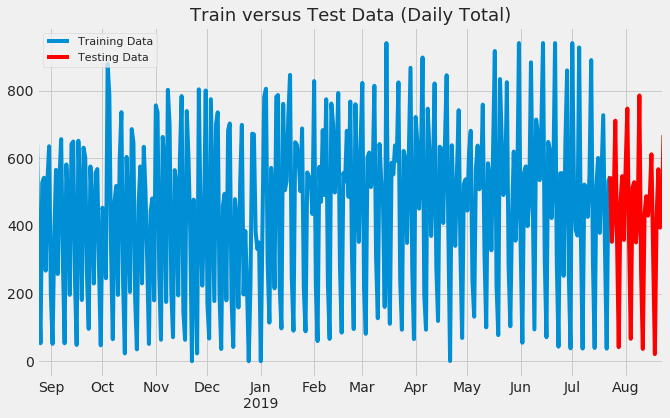

In [0]:
#Graphing the test versus training

train.day_total.plot(figsize=(10,6), label= 'Training Data', fontsize=14, linewidth= 4)
test.day_total.plot(figsize=(10,6), label='Testing Data' , fontsize=14, linewidth= 4, color= 'red')
plt.legend()
plt.title('Train versus Test Data (Daily Total)', fontsize= 18)

# 7. Models

In [0]:
#imports
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt



In [0]:
#create an empty data frame to store all the results of the models
results_m = pd.DataFrame() #results with MAE
results_r = pd.DataFrame() #results with RMSE


## 7.1 Naive Forecast- Establishing a Baseline Measure


*   With this model, we will establish a basline measure to measure all of our models against
*   The Naive forecast *literally* only takes the past value and inserts it into the present timeframe. No calculations, just a simple shifting of data from one timeframe to another.
* This is a very important metric for this data in particular because if we cannot beat the outcome of this Naive forecast, then we truly have random walks on our hands.





In [0]:
#literally JUST taking the value from the past timeframe and inserting into the present forecast

predictions= pd.DataFrame()

for col in test.columns:
    predictions[col]= test[col].shift(1)

In [0]:
#Getting rid of the first NaN row to compute MAE
test2 = test.iloc[1:]
predict= predictions.iloc[1:]

In [0]:
#Computing MAE & RMSE for each column

mae ={}
rmse = {}
for col in test2.columns:
  mae [col]= round(mean_absolute_error(test2[col], predict[col]), 3)
  rmse [col]= round(sqrt(mean_squared_error(test2[col], predict[col])), 3)

#adding the results to the results data frame
results_m["naive"]= mae.values()
results_r["naive"]= rmse.values()

Text(0.5, 1.0, 'Naive Model Prediction (Daily Total)')

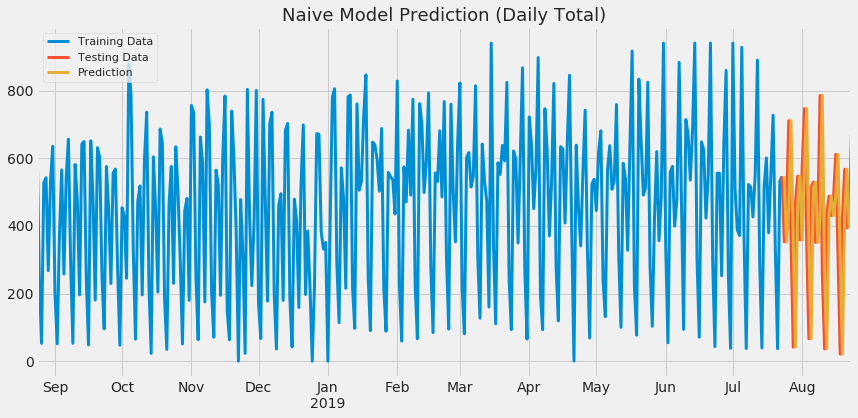

In [0]:
#plotting how well the Naive Model did
train.day_total.plot(figsize=(13,6), label= 'Training Data', fontsize=14, linewidth= 3)
test.day_total.plot(figsize=(13,6), label='Testing Data' , fontsize=14, linewidth= 3)
predictions.day_total.plot(figsize=(13,6), label='Prediction' , fontsize=14, linewidth= 3)
plt.legend()
plt.title('Naive Model Prediction (Daily Total)', fontsize= 18)

Text(0.5, 1.0, 'Naive Model Prediction (Daily Total)')

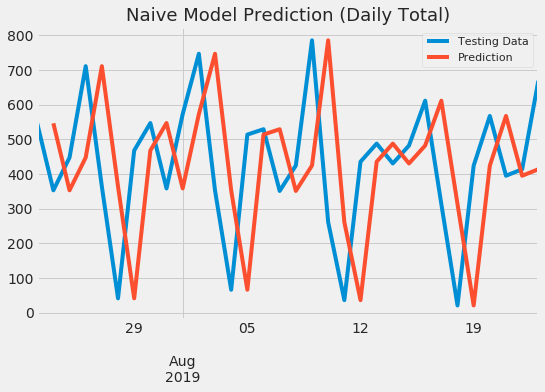

In [0]:
# UPCLOSE SHOT of how well the Naive Model did
test.day_total.plot(figsize=(8,5), label='Testing Data' , fontsize=14, linewidth= 4)
predictions.day_total.plot(figsize=(8,5), label='Prediction' , fontsize=14, linewidth= 4)
plt.legend()
plt.title('Naive Model Prediction (Daily Total)', fontsize= 18)

#### INSIGHTS
*Look how good the naive model does! Just kidding... it fits the actual data so well because your literally just taking the value from yesterday for today. Thus, it looks like its a great fit when in reality it definitely is not so.*

## 7.2 Simple Moving Average- Another Basic Model

* Averages equally the amount of past periods you specify
* Will use some gridsearch methods to figure out the optimal time period to go backwards
* Then I will calculate each time period per category


In [0]:
#Using grid search to find the optimal number of past periods for each given item, and then 
#training and testing for that item and appending the results to the results dataframe

#creating containers
best = {}
mae ={}
rmse = {}
mavg = test.copy()

for col in test.columns:
  
  #figuring out which past time frame is the best measure
  for i in range(1,60):
    mavg["sma"] = train[col].rolling(window= i).mean().iloc[-1]
    mavg.dropna(inplace= True) #get rid of the NaNs generated from the moving average window
    best[i] = mean_absolute_error(mavg[col], mavg.sma)
    
  #returning the optimal past time period for this particular item
  lowest = min(best, key=lambda k: best[k])
  
  #retraining on the optimal time period
  mavg["sma"] = train[col].rolling(window= lowest).mean().iloc[-1]
  mavg.dropna(inplace= True)
  
  #Adding results to metric dictionaries
  mae [col] = round(mean_absolute_error(mavg[col], mavg.sma), 3)
  rmse[col] = round(sqrt(mean_squared_error(mavg[col], mavg.sma)),3)

#adding the results to the results data frame
results_m["sma"]= mae.values()
results_r["sma"]= rmse.values()

Text(0.5, 1.0, 'Simple Moving Average Forecast for Daily Total')

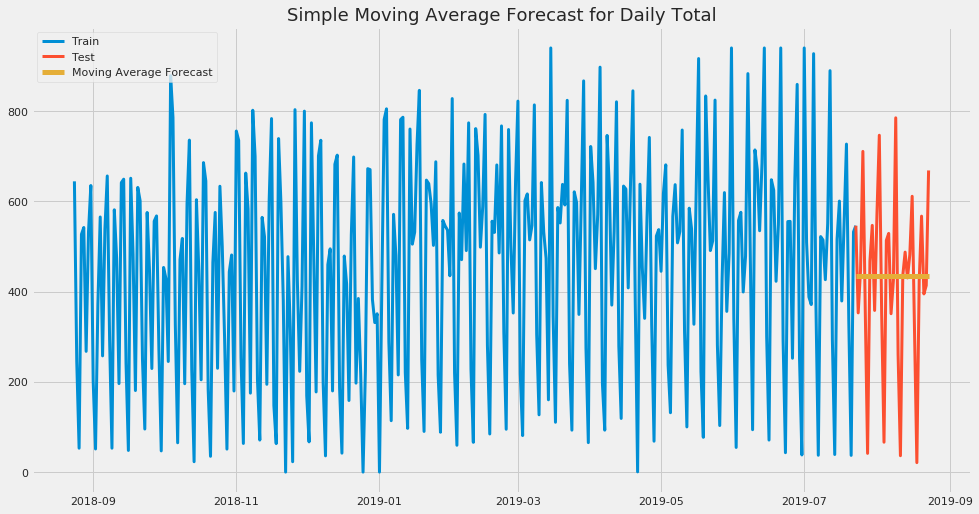

In [0]:
#visualizing SMA

plt.figure(figsize=(15,8))
plt.plot(train['day_total'], label='Train', linewidth=3)
plt.plot(test['day_total'], label='Test', linewidth= 3)
plt.plot(mavg['sma'], label='Moving Average Forecast', linewidth= 5)
plt.legend(loc='best')
plt.title("Simple Moving Average Forecast for Daily Total", fontsize= 18)

## 7.3 Simple Moving Median


*   Because we have a lot of outliers in this dataset, I wanted to try a moving median to help more accurately estimate with outliers
*   Code is the same as above, except taking the median instead of the mean



In [0]:
#Try the same thing with the simple moving median

best = {}
mae ={}
rmse = {}
mmed = test.copy()

for col in test.columns:
  
  #figuring out which past time frame is the best measure
  for i in range(1,60):
    mmed["sma"] = train[col].rolling(window= i).median().iloc[-1]
    mmed.dropna(inplace= True)#get rid of the NaNs generated from the moving average window
    best[i] = mean_absolute_error(mmed[col], mmed.sma)
    
  #returning the best time period for this item
  lowest = min(best, key=lambda k: best[k])
  
  #retraining on the best time period
  mmed["sma"] = train[col].rolling(window= lowest).median().iloc[-1]
  mmed.dropna(inplace= True)
  
  #Adding results to metric dictionaries
  mae [col] = round(mean_absolute_error(mmed[col], mmed.sma), 3)
  rmse[col] = round(sqrt(mean_squared_error(mmed[col], mmed.sma)),3)

#adding the results to the results data frame
results_m["smm"]= mae.values()
results_r["smm"]= rmse.values()

Text(0.5, 1.0, 'Comparing SMA & SMM Forecasts for Daily Total')

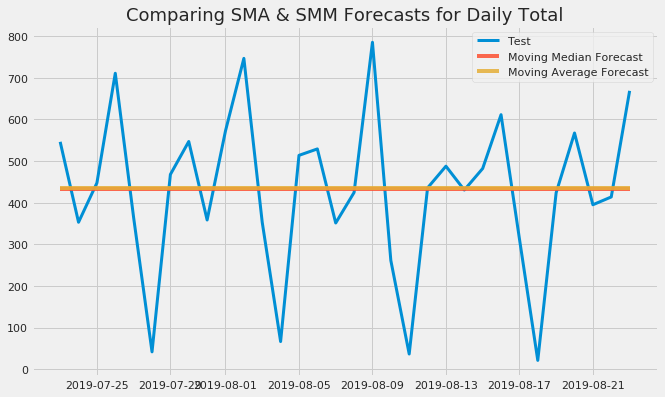

In [0]:
#CLOSE UP: visualizing the SMA & SMM Performance

plt.figure(figsize=(10,6))
#plt.plot(train['day_total'], label='Train', linewidth=3)
plt.plot(test['day_total'], label='Test', linewidth= 3)
plt.plot(mmed['sma'], label='Moving Median Forecast', linewidth= 4, alpha= .85)
plt.plot(mavg['sma'], label='Moving Average Forecast', linewidth= 4, alpha= .85)
plt.legend(loc='best')
plt.title("Comparing SMA & SMM Forecasts for Daily Total", fontsize= 18)

#### Insights
* The SMA and MMA perform very similar and both reflect a similar performance level
* If these techniques prove to be the most successful, I will need to group the dates by week to produce a once a week forecast for these items.
 

## 7.4 Simple Exponential Smoothing
* Gives higher weights to recent data, and lower weights to older data and then takes the average of the values with the weights taken into account.

In [0]:
#Using grid search to find the optimal alpha for each given item, and then 
#training and testing for that item and appending the results to the results dataframe

best = {}
mae ={}
rmse = {}
alphas= [.1, .2, .3, .4, .5, .6, .7, .8, .9]
ses = test.copy()

for col in test.columns:
  
  #figuring out which past time frame is the best measure
  for alpha in alphas:
    fit = SimpleExpSmoothing(np.asarray(train[col])).fit(smoothing_level= alpha,optimized=False)
    ses['ses'] = fit.forecast(len(test))
    best[alpha] = mean_absolute_error(ses[col], ses.ses)
    
  #returning the best alpha for this item
  lowest = min(best, key=lambda k: best[k])
  
  #retraining on the best alpha
  fit = SimpleExpSmoothing(np.asarray(train[col])).fit(smoothing_level= lowest,optimized=False)
  ses['ses'] = fit.forecast(len(test))
  
  #Adding results to metric dictionaries
  mae [col] = round(mean_absolute_error(ses[col], ses.ses), 3)
  rmse[col] = round(sqrt(mean_squared_error(ses[col], ses.ses)),3)

#adding the results to the results data frame
results_m["ses"]= mae.values()
results_r["ses"]= rmse.values()

Text(0.5, 1.0, 'Simple Exponential Smoothing Forecast for Daily Total')

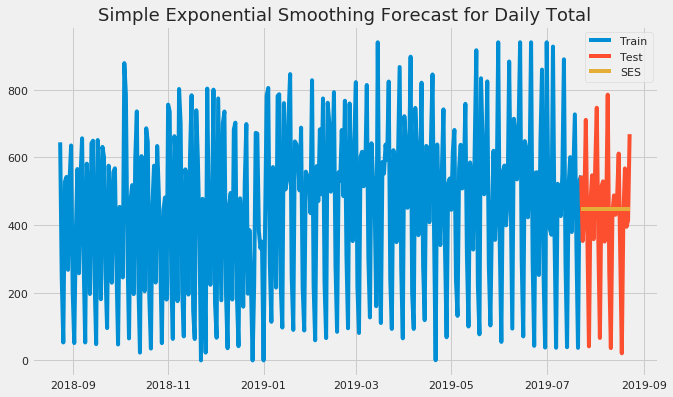

In [0]:
#visualizing SES

plt.figure(figsize=(10,6))
plt.plot(train['day_total'], label='Train')
plt.plot(test['day_total'], label='Test')
plt.plot(ses['ses'], label='SES', linewidth= 4)
plt.legend(loc='best')
plt.title("Simple Exponential Smoothing Forecast for Daily Total", fontsize= 18)


####Insights
* Very similar results to SMM and SMA

## 7.5 Holt’s Linear Trend method 

* Holts Linear Trend will do the same as the exponential smoothing, but also take into account the trend of the data
* More computationally expensive because of the two parameter gridsearch


In [0]:
#Using grid search to find the optimal alpha & slope for each given item, and then 
#training and testing for that item and appending the results to the results dataframe

best = {}
mae ={}
rmse = {}
alphas= [.1, .2, .3, .4, .5, .6, .7, .8, .9]
slopes = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
hlt = test.copy()

for col in test.columns:
  
  for alpha in alphas:
    for slope in slopes:  
      fit = Holt(np.asarray(train[col])).fit(smoothing_level = alpha, smoothing_slope = slope)
      hlt['hlt'] = fit.forecast(len(test))
      best[(alpha, slope)] = mean_absolute_error(hlt[col], hlt.hlt)
      
  #returning the best alpha for this item
  lowest = min(best, key=lambda k: best[k])
  
  #retraining on the best alpha
  fit = Holt(np.asarray(train[col])).fit(smoothing_level = lowest[0], smoothing_slope = lowest[1])
  hlt['hlt'] = fit.forecast(len(test))
  
  #Adding results to metric dictionaries
  mae [col] = round(mean_absolute_error(hlt[col], hlt.hlt), 3)
  rmse[col] = round(sqrt(mean_squared_error(hlt[col], hlt.hlt)),3)

#adding the results to the results data frame
results_m["hlt"]= mae.values()
results_r["hlt"]= rmse.values()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Text(0.5, 1.0, 'Holts Linear Trend Forecast for Daily Total')

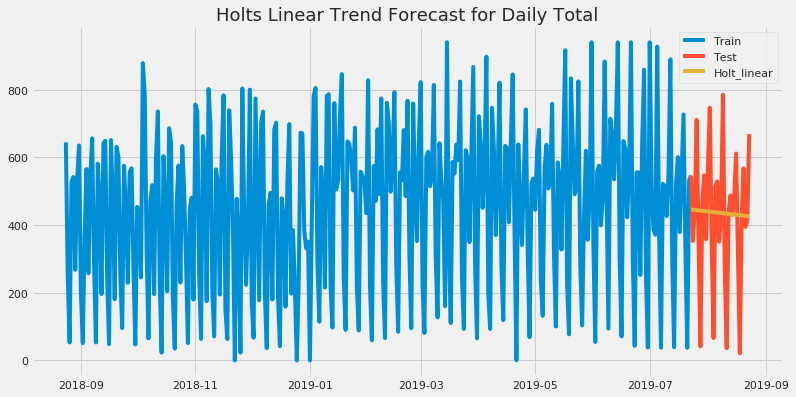

In [0]:
plt.figure(figsize=(12,6))
plt.plot(train['day_total'], label='Train')
plt.plot(test['day_total'], label='Test')
plt.plot(hlt['hlt'], label='Holt_linear', linewidth= 4)
plt.legend(loc='best')
plt.title("Holts Linear Trend Forecast for Daily Total", fontsize= 18)

#### Insights
* This is catching more of an overall trend than the averages could do. We will see how to MAE and RMSE compare.

## 7.6 Holt’s Winter Method 

* This method is suposed to capture the seasonality 
* Holts Winter Method does triple exponential smoothing to try to uncover seasonality and trend.
* You must calculate the correct seasonality

In [0]:
#Using grid search to find the optimal number of seasons for each given item, and then 
#training and testing for that item and appending the results to the results dataframe

###CAUTION: TAKES A LONG TIME TO RUN!

best = {}
mae ={}
rmse = {}
hwm = test.copy()

for col in test.columns:
  
  #figuring out which past time frame is the best measure
  for num in range(2, 30):
    fit = ExponentialSmoothing(np.asarray(train[col]) ,seasonal_periods = num ,trend='add', seasonal='add',).fit()
    hwm['hwm'] = fit.forecast(len(test))
    best[num] = mean_absolute_error(hwm[col], hwm.hwm)
    
  #returning the best alpha for this item
  lowest = min(best, key=lambda k: best[k])
  
  #retraining on the best alpha
  fit = ExponentialSmoothing(np.asarray(train[col]) ,seasonal_periods = lowest ,trend='add', seasonal='add',).fit()
  hwm['hwm'] = fit.forecast(len(test))
  
  #Adding results to metric dictionaries
  mae [col] = round(mean_absolute_error(hwm[col], hwm.hwm), 3)
  rmse[col] = round(sqrt(mean_squared_error(hwm[col], hwm.hwm)),3)

#adding the results to the results data frame
results_m["hwm"]= mae.values()
results_r["hwm"]= rmse.values()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

Text(0.5, 1.0, 'UP CLOSE: Holts Winter Method Forecast on Daily Total')

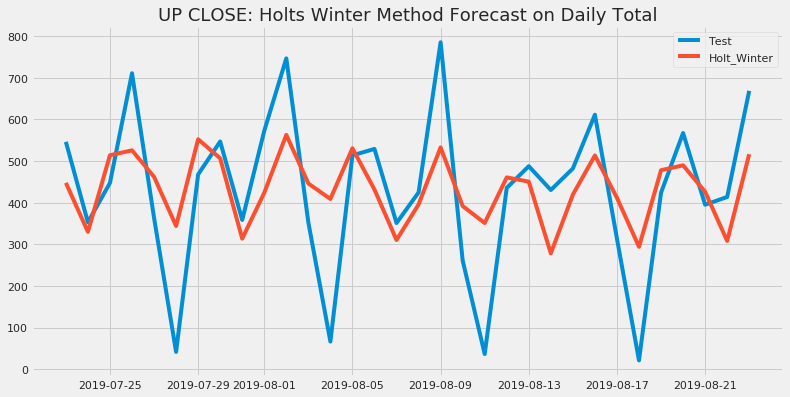

In [0]:
plt.figure(figsize=(12,6))
#plt.plot( train['day_total'], label='Train')
plt.plot(test['day_total'], label='Test')
plt.plot(hwm['hwm'], label='Holt_Winter', linewidth= 4)
plt.legend(loc='best')
plt.title("UP CLOSE: Holts Winter Method Forecast on Daily Total", fontsize= 18)

#### Insights
* This model seems to have done the best at capturing changes in trend
* We will see how well it did overall when we compare all the different models

## 7.7 Prophet Model

*Now that we've established a few baseline and classical models, let's compare that against the performance of the prophet model.*

#### Some background on Prophet:

Prophet is optimized for the business forecast tasks we have encountered at Facebook, which typically have any of the following characteristics:

* hourly, daily, or weekly observations with at least a few months (preferably a year) of history
* strong multiple “human-scale” seasonalities: day of week and time of year
* important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
* a reasonable number of missing observations or large outliers
* historical trend changes, for instance due to product launches or logging changes
* trends that are non-linear growth curves, where a trend hits a natural limit or saturates

#### How Prophet works:

At its core, the Prophet procedure is an additive regression model with four main components:

* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.


In [0]:
#installs
%pip install pystan
%pip install fbprophet
from fbprophet import Prophet

In [0]:
#resetting the data frame dates for the prophet model
dfqty.reset_index(inplace= True)
train.reset_index(inplace= True)

In [0]:
final = pd.DataFrame()
final['index']= train['index']#transferring over the date column
m_results= []
r_results = []

for num in range (1, len(train.columns)):
    col = dfqty.columns[num] #iterating through the columns minus the index column
    
    #renaming columns to suit the prophet needs
    new_df= train[['index', col]] 
    new_df.columns = ['ds', 'y']
    
    #fitting and forecasting
    m = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True) #instantiating the prophet model, and customizing the prophet model for a 95% certainaty level
    m.fit(new_df)
    future = m.make_future_dataframe(periods=32) #forecast the next 32 days (matching up with our test set)
    forecast = m.predict(future)   
    
    #adding columns to the final df
    final['yhat']= forecast['yhat']
    final['y'] = dfqty[col]
    
    #calculating MAE & RMSE
    m_results.append(round(mean_absolute_error(final['y'], final['yhat']), 3))
    r_results.append(round(sqrt(mean_squared_error(final['y'], final['yhat'])), 3))
    
    #renaming columns to be specific to the category
    final = final.rename(columns={'yhat': 'yhat_'+ str(col), 'y':'y_'+ str(col)})
                                  
results_m['prophet']= m_results
results_r['prophet']= r_results

  

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


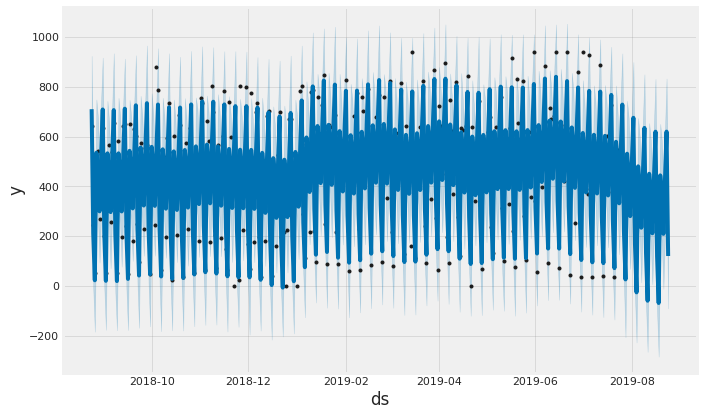

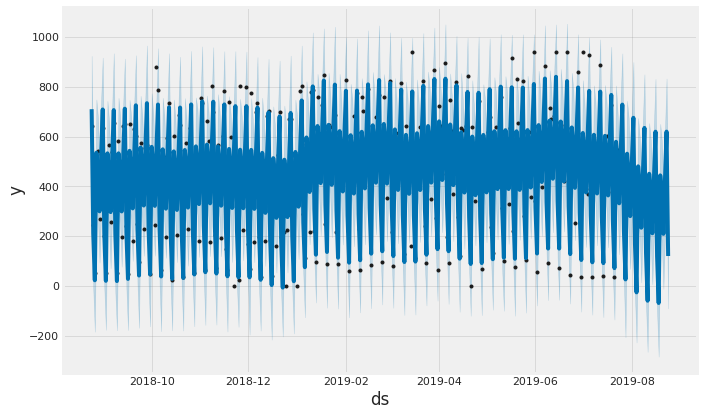

In [0]:
m.plot(forecast)

In [0]:
#testing daily, weekly, monthly, quarterly seasonality

final = pd.DataFrame()
final['index']= train['index']#transferring over the date column
m_results= []
r_results = []

for num in range (1, len(train.columns)):
    col = dfqty.columns[num] #iterating through the columns minus the index column
    
    #renaming columns to suit the prophet needs
    new_df= train[['index', col]] 
    new_df.columns = ['ds', 'y']
    
    #fitting and forecasting
    m = Prophet(interval_width=0.95, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False).add_seasonality(name= 'daily', period= 1, fourier_order=15).add_seasonality(name= 'weekly', period= 7, fourier_order=20).add_seasonality(name= 'monthly', period= 30.5, fourier_order=12).add_seasonality(name= 'quarterly', period= 365.25/4, fourier_order=5) #instantiating the prophet model, and customizing the prophet model for a 95% certainaty level
    m.fit(new_df)
    future = m.make_future_dataframe(periods=32) #forecast the next 32 days (matching up with our test set)
    forecast = m.predict(future)   
    
    #adding columns to the final df
    final['yhat']= forecast['yhat']
    final['y'] = dfqty[col]
    
    #calculating MAE & RMSE
    m_results.append(round(mean_absolute_error(final['y'], final['yhat']), 3))
    r_results.append(round(sqrt(mean_squared_error(final['y'], final['yhat'])), 3))
    
    #renaming columns to be specific to the category
    final = final.rename(columns={'yhat': 'yhat_'+ str(col), 'y':'y_'+ str(col)})
                                  
results_m['prophet_dwmq']= m_results
results_r['prophet_dwmq']= r_results

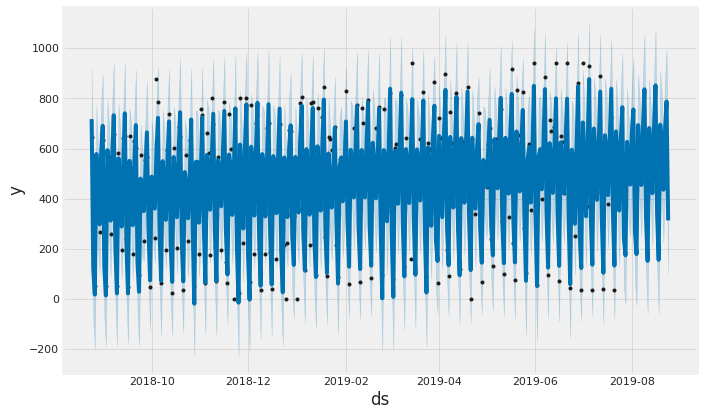

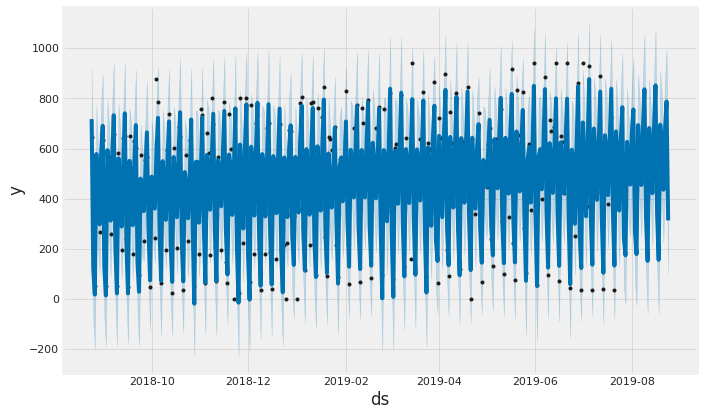

In [0]:
m.plot(forecast)

In [0]:
#Testing Adding Holidays + seasonalities to the prophet model

#dataframe of annual US Public Holidays + 2017 Presidential Inauguration over training and forecasting periods 

ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2019-01-01'])})  
farm = pd.DataFrame({'holiday': 'Farm', 'ds' : pd.to_datetime(['2019-07-04'])})
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day', 'ds' : pd.to_datetime(['2018-11-22'])})
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2018-12-25'])})

holidays = pd.concat([ny, farm, thanks, christ])

final = pd.DataFrame()
final['index']= train['index']#transferring over the date column
m_results= []
r_results = []

for num in range (1, len(train.columns)):
    col = dfqty.columns[num] #iterating through the columns minus the index column
    
    #renaming columns to suit the prophet needs
    new_df= train[['index', col]] 
    new_df.columns = ['ds', 'y']
    
    #fitting and forecasting
    m = Prophet(interval_width=0.95, holidays= holidays, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False).add_seasonality(name= 'daily', period= 1, fourier_order=15).add_seasonality(name= 'weekly', period= 7, fourier_order=20).add_seasonality(name= 'monthly', period= 30.5, fourier_order=12).add_seasonality(name= 'quarterly', period= 365.25/4, fourier_order=5) #instantiating the prophet model, and customizing the prophet model for a 95% certainaty level
    m.fit(new_df)
    future = m.make_future_dataframe(periods=32) #forecast the next 32 days (matching up with our test set)
    forecast = m.predict(future)   
    
    #adding columns to the final df
    final['yhat']= forecast['yhat']
    final['y'] = dfqty[col]
    
    #calculating MAE & RMSE
    m_results.append(round(mean_absolute_error(final['y'], final['yhat']), 3))
    r_results.append(round(sqrt(mean_squared_error(final['y'], final['yhat'])), 3))
    
    #renaming columns to be specific to the category
    final = final.rename(columns={'yhat': 'yhat_'+ str(col), 'y':'y_'+ str(col)})
                                  
results_m['prophet_hday']= m_results
results_r['prophet_hday']= r_results

In [0]:
#OTHER PROPHET FEATURES TO USE:

#Basics:

# m = Prophet(interval_width=0.95)
# m.fit(fruit)
# forecast = m.predict(future_dates)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# fig = m.plot(forecast)#who fruit dataset

# from fbprophet.diagnostics import cross_validation
# df_cv = cross_validation(m, initial='311 days', horizon = '53 days')
# df_cv.head()

# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p

# from fbprophet.plot import plot_cross_validation_metric
# fig = plot_cross_validation_metric(df_cv, metric='mae')

In [0]:
#Setting back the indexes
dfqty.set_index('index', inplace= True)
train.set_index('index', inplace= True)

# Reviewing Model Results


*   Which models performed the best?



In [0]:
#Setting index to the different PLUs
results_m.set_index(dfqty.columns, inplace= True)
results_r.set_index(dfqty.columns, inplace= True)

In [0]:
# results_m.drop(columns=['best'], inplace= True)
# results_r.drop(columns=['best'], inplace= True)

In [0]:
#Creating a "best model" column for the results spreadsheet
results_m['best'] = results_m.idxmin(axis=1)
results_r['best'] = results_r.idxmin(axis=1)

results_m['best_forecast'] = results_m.min(axis=1)
results_r['best_forecast'] = results_r.min(axis=1)


In [0]:
results_r.head()

naive    sma    smm  ...  prophet_hday          best  best_forecast
item                         ...                                           
10218B  0.000  0.000  0.000  ...         1.591         naive          0.000
10219   4.441  2.800  2.800  ...         3.832           sma          2.800
10221   0.762  0.729  0.729  ...         2.832           hwm          0.724
10230   7.216  4.448  4.436  ...         3.460  prophet_hday          3.460
10236   1.760  1.442  1.487  ...         2.094           hwm          1.323

[5 rows x 11 columns]

(0, 35)

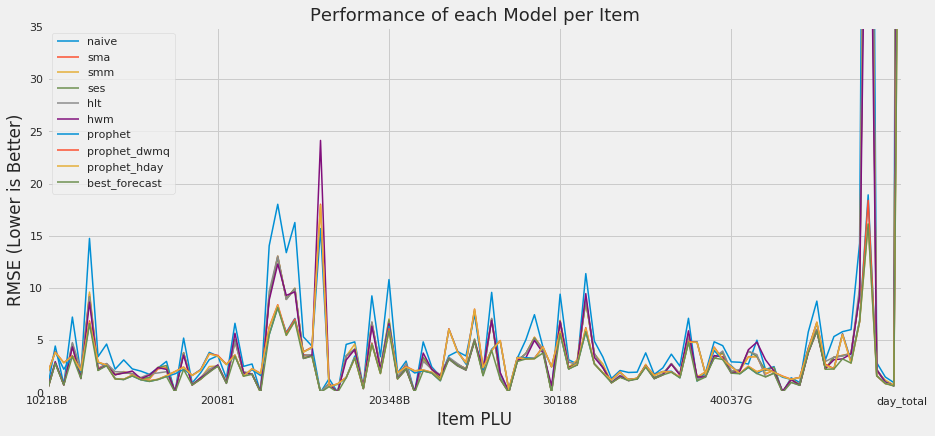

In [0]:
results_r.loc[:, results_r.columns != 'best'].plot(figsize=(13,6), linewidth= 1.5)
plt.tight_layout()
plt.xlabel("Item PLU")
plt.ylabel("RMSE (Lower is Better)")
plt.title("Performance of each Model per Item",fontsize= 18)
plt.ylim(0,35)

Text(0.5, 1.0, 'Count: Best Model Performance per Item (RMSE)')

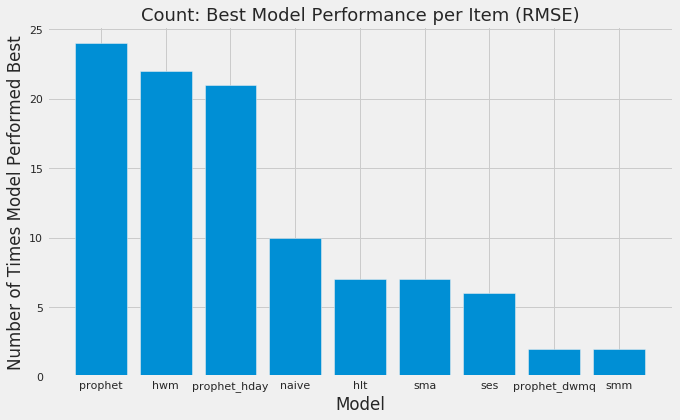

In [0]:
#sns.countplot(x="best", data=results_r)
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
counts = results_r["best"].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel("Model")
plt.ylabel("Number of Times Model Performed Best")
plt.title("Count: Best Model Performance per Item (RMSE)",fontsize= 18)


Text(0.5, 1.0, 'Count: Best Model Performance per Item (MAE)')

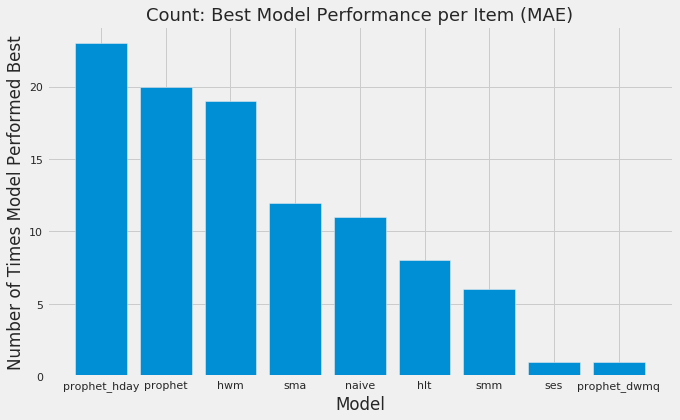

In [0]:
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
counts = results_m["best"].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel("Model")
plt.ylabel("Number of Times Model Performed Best")
plt.title("Count: Best Model Performance per Item (MAE)",fontsize= 18)

In [0]:
#Calculating the percent of Naive forecasts
count= results_r['best'].value_counts().to_dict()
n_num= count['naive']
print (f"Percent of items that CAN'T beat a naive forecast = {n_num/ results_r.shape[0]*100:.2f}%")

Percent of items that CAN'T beat a naive forecast = 9.90%


In [0]:
rm2=results_m.drop(columns=['best',	'smm',	'ses', 'hlt','prophet', 'prophet_dwmq'])
rr2=results_r.drop(columns=['best',	'smm',	'ses',	'hlt', 'prophet', 'prophet_dwmq'])

#Creating a "best model" column for the results spreadsheet
rm2['best'] = rm2.idxmin(axis=1)
rr2['best'] = rr2.idxmin(axis=1)

Text(0.5, 1.0, 'Count: Best Model Performance per Item (RMSE)')

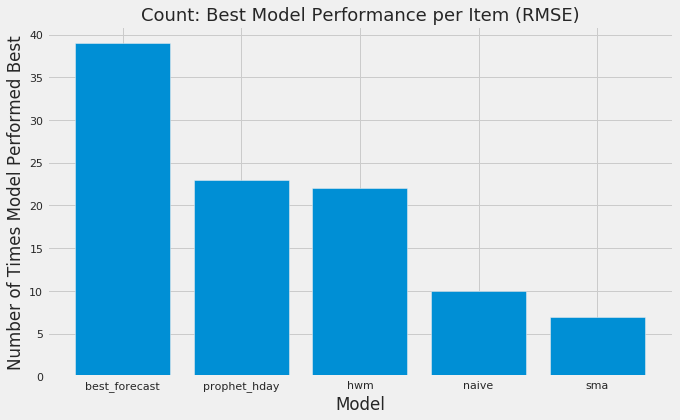

In [0]:
#sns.countplot(x="best", data=results_r)
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
counts = rr2["best"].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel("Model")
plt.ylabel("Number of Times Model Performed Best")
plt.title("Count: Best Model Performance per Item (RMSE)",fontsize= 18)

Text(0.5, 1.0, 'Count: Best Model Performance per Item (MAE)')

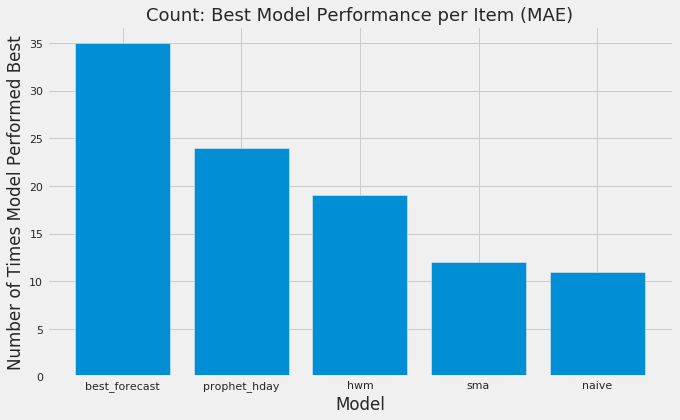

In [0]:
#sns.countplot(x="best", data=results_r)
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
counts = rm2["best"].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel("Model")
plt.ylabel("Number of Times Model Performed Best")
plt.title("Count: Best Model Performance per Item (MAE)",fontsize= 18)

# INSIGHTS

1. prophet with the seasonalities and holidays performs the best
2. The best three models are prophet_holiday, SMA, HWM account for a better RMSE or MAE for 91ish% of the data
3. The naive model seems to have a persistant core group of around 11% that cannot be modelled.

# Next Steps:


1. Try Coercing the outliers
2. Try LGMBoost model or XG Boost


In [0]:
results_m.to_csv(r'/content/drive/My Drive/Capstone_2/data/coerced_results_m.csv', index= 'invdate', header=True)
results_r.to_csv(r'/content/drive/My Drive/Capstone_2/data/coerced_results_r.csv', index= 'invdate', header=True)